## Imports

In [1]:
import math
import os
import random

import git
import imageio
import magnum as mn
import numpy as np

import cv2

%matplotlib inline
from matplotlib import pyplot as plt

# function to display the topdown map
from PIL import Image

import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut

repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
print(f"data_path = {data_path}")
# @markdown Optionally configure the save path for video output:
output_directory = os.path.join(
    dir_path, "examples/tutorials/nav_output/"
)  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)
if not os.path.exists(output_path):
    os.mkdir(output_path)

from scripts_utils import *

import quaternion


/home/jack/miniconda3/envs/habitat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


data_path = /home/jack/Desktop/habitat-sim/data


## Settings

In [2]:
show_video = True
do_make_video = True
display = True

# import the maps module alone for topdown mapping
if display:
    from habitat.utils.visualizations import maps

meters_per_pixel = 0.025

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


In [3]:
import os

def update_string_with_glb_file(data_folder, str_value):
    file_paths = []
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if file.endswith('.glb'):
                # Extract the file name without extension
                glb_file_name = os.path.splitext(file)[0]
                
                # Replace the string value with the .glb file name
                str_value = glb_file_name
                
                # Full path of the .glb file
                glb_file_path = os.path.join(root, file)
                
                file_paths.append(glb_file_path)
                
                # If you need to save this update somewhere, you can add your saving logic here
                
    return file_paths

# Example usage
data_folder = data_path + '/scene_datasets/hm3d-minival-habitat-v0.2/' # Root data folder containing subfolders with .glb files
initial_str_value = "initial_value"

# Update the string value with the .glb file name
updated_str_value = update_string_with_glb_file(data_folder, initial_str_value)

print(f"Updated string value: {updated_str_value}")

Updated string value: ['/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00804-BHXhpBwSMLh/BHXhpBwSMLh.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00807-rsggHU7g7dh/rsggHU7g7dh.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00809-Qpor2mEya8F/Qpor2mEya8F.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00803-k1cupFYWXJ6/k1cupFYWXJ6.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00808-y9hTuugGdiq/y9hTuugGdiq.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00802-wcojb4TFT35/wcojb4TFT35.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00805-SUHsP6z2gcJ/SUHsP6z2gcJ.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00806-tQ5s4ShP627/tQ5s4ShP627.basis.glb', '/home/jack/Deskt

In [4]:
# This is the scene we are going to load.
# we support a variety of mesh formats, such as .glb, .gltf, .obj, .ply
# test_scene = os.path.join(
#     data_path, "scene_datasets/hm3d-minival-habitat-v0.2/00804-BHXhpBwSMLh/BHXhpBwSMLh.basis.glb"
# )

# pick a random index between 0 and len(updated_str_value)
random_index = random.randint(0, len(updated_str_value)-1)
test_scene = updated_str_value[random_index]

rgb_sensor = True

sim_settings = {
    "scene": test_scene,  # Scene path
    "default_agent": 0,  # Index of the default agent
    "sensor_height": 0.0, #1.5,  # Height of sensors in meters, relative to the agent
    "agent_height": 1.0,  # Height of the agent in meters
    "agent_radius": 0.1,  # Radius of the agent in meters
    "width": 256,  # Spatial resolution of the observations
    "height": 256, 
    "sensor_hfov": 45,  # Horizontal field of view of the sensors
    "color_sensor": rgb_sensor,  # RGB sensor
    "seed": 1,  # used in the random navigation
    "enable_physics": True,  # kinematics only
}

In [5]:
# test_scene_file = '/home/chitianqilin/habitat-source/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00804-BHXhpBwSMLh/BHXhpBwSMLh.basis.glb'
 

In [6]:
cfg = make_cfg(sim_settings)
# Needed to handle out of order cell run in Jupyter
try:  # Got to make initialization idiot proof
    sim.close()
except NameError:
    pass
sim = habitat_sim.Simulator(cfg)

Renderer: Quadro P1000/PCIe/SSE2 by

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring


 NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 555.42.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[13:02:26:828609]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.
[13:02:26:828867]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: File/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00803-k1cupFYWXJ6/k1cupFYWXJ6.basis.scndoes not exist.  Aborting load.
[13:02:26:828884]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither Semantic

## Initialize Agent

In [7]:
# initialize an agent
agent = sim.initialize_agent(sim_settings["default_agent"])

# Set agent state
agent_state = habitat_sim.AgentState()
agent_state.position = np.array([1, 1, 0.0])  # in world space
agent.set_state(agent_state)

# Get agent state
agent_state = agent.get_state()
print("agent_state: position", agent_state.position, "rotation", agent_state.rotation)

sensor_spec = sim._sensors.get("color_sensor")
print("sensor_spec: ", sensor_spec._spec.__dict__)



agent_state: position [1. 1. 0.] rotation quaternion(1, 0, 0, 0)
sensor_spec:  {'__noise_model_kwargs': {}}


In [70]:
# Print semantic annotation information (id, category, bounding box details)
# about levels, regions and objects in a hierarchical fashion
scene = sim.semantic_scene
print_scene_recur(scene)

House has 0 levels, 0 regions and 0 objects
House center:[0. 0. 0.] dims:[-inf -inf -inf]


## Compute NavMesh

Successfully snapped point to: [0.         0.12744904 0.        ]
Agent state: AgentState(position=array([0.        , 0.12744904, 0.        ], dtype=float32), rotation=quaternion(0.7109135389328, -0, -0.703279376029968, -0), sensor_states={'color_sensor': SixDOFPose(position=array([0.        , 0.12744904, 0.        ], dtype=float32), rotation=quaternion(0.7109135389328, 0, -0.703279376029968, 0))})
 position = [0.         0.12744904 0.        ]
 rotation = quaternion(0.7109135389328, -0, -0.703279376029968, -0)
 orientation (about Y) = 1.56
rgb {'color_sensor': array([[[ 88,  79,  79, 255],
        [ 88,  79,  79, 255],
        [ 88,  79,  79, 255],
        ...,
        [ 91,  81,  82, 255],
        [ 92,  83,  84, 255],
        [ 89,  83,  81, 255]],

       [[ 87,  79,  79, 255],
        [ 88,  79,  79, 255],
        [ 87,  78,  78, 255],
        ...,
        [ 93,  84,  85, 255],
        [ 92,  84,  84, 255],
        [ 89,  85,  81, 255]],

       [[ 86,  78,  78, 255],
        [ 87

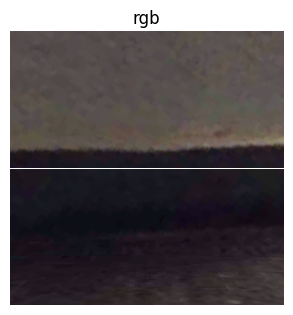


Display topdown map with agent:


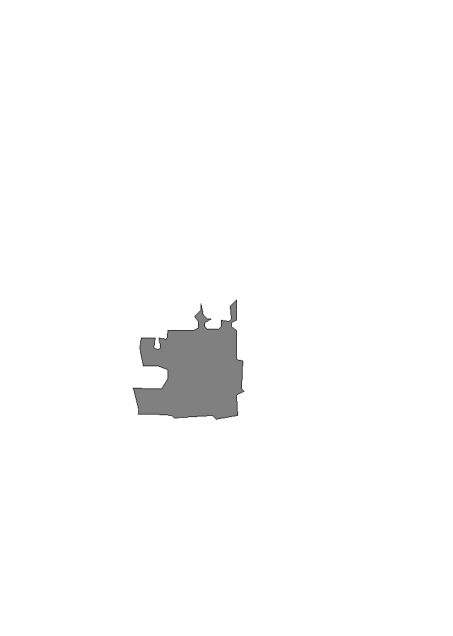

{'color_sensor': array([[[ 57,  48,  57, 255],
         [ 57,  48,  57, 255],
         [ 57,  48,  57, 255],
         ...,
         [ 49,  40,  49, 255],
         [ 49,  40,  49, 255],
         [ 49,  40,  49, 255]],
 
        [[ 57,  48,  57, 255],
         [ 57,  48,  57, 255],
         [ 57,  48,  57, 255],
         ...,
         [ 49,  40,  49, 255],
         [ 49,  40,  49, 255],
         [ 49,  40,  49, 255]],
 
        [[ 57,  48,  57, 255],
         [ 57,  48,  57, 255],
         [ 57,  48,  57, 255],
         ...,
         [ 49,  40,  49, 255],
         [ 49,  40,  49, 255],
         [ 49,  40,  49, 255]],
 
        ...,
 
        [[133, 125, 117, 255],
         [133, 125, 117, 255],
         [133, 125, 117, 255],
         ...,
         [  0,   0,   0, 255],
         [  0,   0,   0, 255],
         [  0,   0,   0, 255]],
 
        [[133, 125, 117, 255],
         [133, 125, 117, 255],
         [133, 125, 117, 255],
         ...,
         [  0,   0,   0, 255],
         [  0,   0,

In [71]:
## Recompute NavMesh:

# Take a moment to edit some parameters and visualize the resulting NavMesh. Consider agent_radius and agent_height as the most impactful starting point. Note that large variations from the defaults for these parameters (e.g. in the case of very small agents) may be better supported by additional changes to cell_size and cell_height.
navmesh_settings = habitat_sim.NavMeshSettings()

# Choose Habitat-sim defaults (e.g. for point-nav tasks), or custom settings.
use_custom_settings = True  # @param {type:"boolean"}
sim.navmesh_visualization = True  # @param {type:"boolean"}
navmesh_settings.set_defaults()
if use_custom_settings:
    #@markdown Configure the following NavMeshSettings for customized NavMesh recomputation.
    #@markdown **Voxelization parameters**:
    navmesh_settings.cell_size = 0.05 #default = 0.05
    navmesh_settings.cell_height = 0.2 #default = 0.2

    #@markdown **Agent parameters**:
    navmesh_settings.agent_height = sim_settings["agent_height"] #default = 1.5
    navmesh_settings.agent_radius = sim_settings["agent_radius"] #default = 0.1
    navmesh_settings.agent_max_climb = 0.2 #default = 0.2
    navmesh_settings.agent_max_slope = 45 # default = 45.0
    
    # @markdown **Navigable area filtering options**:
    navmesh_settings.filter_low_hanging_obstacles = True  # default = True
    navmesh_settings.filter_ledge_spans = True # default = True
    navmesh_settings.filter_walkable_low_height_spans = True  # default = True

    #@markdown **Detail mesh generation parameters**:
    #@markdown For more details on the effects
    navmesh_settings.region_min_size = 20 #default = 20
    navmesh_settings.region_merge_size = 20 #default = 20
    navmesh_settings.edge_max_len = 12.0 #default = 12.0
    navmesh_settings.edge_max_error = 1.3 #default = 1.3
    navmesh_settings.verts_per_poly = 6.0 #default = 6.0
    navmesh_settings.detail_sample_dist = 6.0 #default = 6.0
    navmesh_settings.detail_sample_max_error = 1.0 # default = 1.0

    # @markdown **Include STATIC Objects**:
    # @markdown Optionally include all instanced RigidObjects with STATIC MotionType as NavMesh constraints.
    navmesh_settings.include_static_objects = True  # @param {type:"boolean"}
    # default = False

navmesh_success = sim.recompute_navmesh(sim.pathfinder, navmesh_settings)

if not navmesh_success:
    print("Failed to build the navmesh! Try different parameters?")
else:
    # @markdown **Agent parameters**:
    agent_state = sim.agents[0].get_state()
    set_random_valid_state = False  
    seed = 5  
    sim.seed(seed)
    orientation = 0
    if set_random_valid_state:
        agent_state.position = sim.pathfinder.get_random_navigable_point()
        orientation = random.random() * math.pi * 2.0
    # Optionally configure the agent state (overrides random state):
    set_agent_state = True  # @param {type:"boolean"}
    try_to_make_valid = True  # @param {type:"boolean"}
    if set_agent_state:
        pos_x = 0  # @param {type:"number"}
        pos_y = 0  # @param {type:"number"}
        pos_z = 0.0  # @param {type:"number"}
        # Y axis rotation (radians):
        orientation = 1.56  # @param {type:"number"}
        agent_state.position = np.array([pos_x, pos_y, pos_z])
        if try_to_make_valid:
            snapped_point = np.array(sim.pathfinder.snap_point(agent_state.position))
            if not np.isnan(np.sum(snapped_point)):
                print("Successfully snapped point to: " + str(snapped_point))
                agent_state.position = snapped_point
    if set_agent_state or set_random_valid_state:
        agent_state.rotation = utils.quat_from_magnum(
            mn.Quaternion.rotation(-mn.Rad(orientation), mn.Vector3(0, 1.0, 0))
        )
        sim.agents[0].set_state(agent_state)

    agent_state = sim.agents[0].get_state()
    print("Agent state: " + str(agent_state))
    print(" position = " + str(agent_state.position))
    print(" rotation = " + str(agent_state.rotation))
    print(" orientation (about Y) = " + str(orientation))

    observations = sim.get_sensor_observations()
    rgb = observations["color_sensor"]
    print("rgb", observations)

    if display:
        display_sample(rgb)
        # **Map parameters**:
        agent_pos = agent_state.position
        # topdown map at agent position
        top_down_map = maps.get_topdown_map(
            sim.pathfinder, height=agent_pos[1], meters_per_pixel=meters_per_pixel
        )
        recolor_map = np.array(
            [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
        )
        top_down_map = recolor_map[top_down_map]
        grid_dimensions = (top_down_map.shape[0], top_down_map.shape[1])
        # convert world agent position to maps module grid point
        agent_grid_pos = maps.to_grid(
            agent_pos[2], agent_pos[0], grid_dimensions, pathfinder=sim.pathfinder
        )
        agent_forward = utils.quat_to_magnum(
            sim.agents[0].get_state().rotation
        ).transform_vector(mn.Vector3(0, 0, -1.0))
        agent_orientation = math.atan2(agent_forward[0], agent_forward[2])
        # draw the agent and trajectory on the map
        # maps.draw_agent(
        #     top_down_map, agent_grid_pos, agent_orientation, agent_radius_px=4
        # )
        print("\nDisplay topdown map with agent:")
        display_map(top_down_map)

sim.reset()

In [72]:
print(top_down_map.shape)
print(type(top_down_map))

(970, 683, 3)
<class 'numpy.ndarray'>


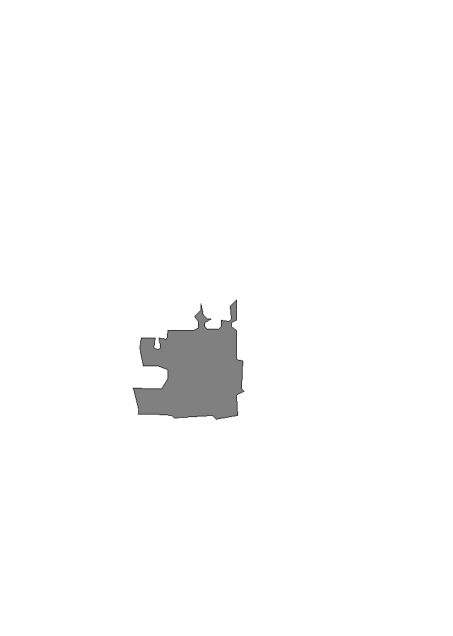

In [73]:
from scipy.ndimage import label, find_objects

# Convert to binary map where 1 is navigable and 0 is not
binary_map = (top_down_map == 128).astype(np.uint8)

# Label connected components
labeled_map, num_features = label(binary_map)

# Find the largest connected component
sizes = np.bincount(labeled_map.ravel())
sizes[0] = 0  # Background size to 0
largest_component_label = sizes.argmax()

# Create a mask for the largest component
largest_component_mask = (labeled_map == largest_component_label)

# Create the final navigation map, keeping the borders as they are
final_navigation_map = np.where(largest_component_mask, 128, 255)

# Ensure the borders of the largest component are kept as they are in the original map
final_navigation_map[top_down_map == 0] = 0

# Display the final navigation map
display_map(final_navigation_map)

In [74]:
top_down_map = (final_navigation_map).astype(np.uint8)

In [75]:
print(top_down_map.shape)
print(type(top_down_map))

(970, 683, 3)
<class 'numpy.ndarray'>


Number of samples: 5
Number of sampled points: 5


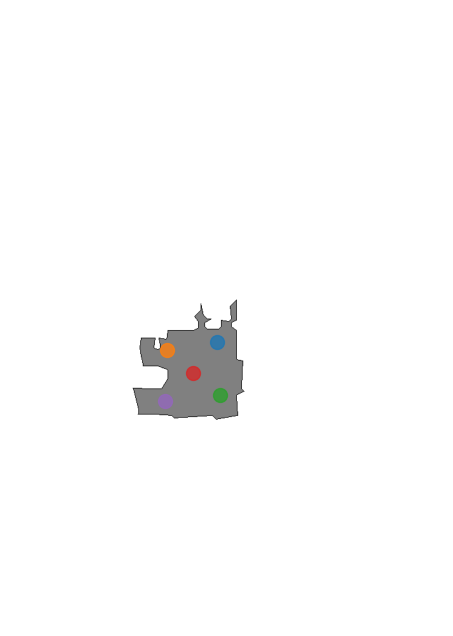

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d
from PIL import Image
from scipy.spatial import KDTree



# Function to get all navigable points (where the value is [128, 128, 128])
def get_navigable_points(img_array):
    """
    Get all navigable points (where the value is [128, 128, 128]) from the image array.

    Parameters:
    img_array (np.array): Image array representing the top-down map.

    Returns:
    np.array: Array of (x, y) coordinates of navigable points.
    """
    navigable_points = []
    for y in range(img_array.shape[0]):
        for x in range(img_array.shape[1]):
            if np.all(img_array[y, x] == [128, 128, 128]):
                navigable_points.append((x, y))
    return np.array(navigable_points)

# Function to sample points from the navigable points using K-means clustering
def sample_navigable_points(navigable_points, num_samples):
    """
    Sample points from the navigable points using K-means clustering.

    Parameters:
    navigable_points (np.array): Array of (x, y) coordinates of navigable points.
    num_samples (int): Number of points to sample.

    Returns:
    np.array: Array of (x, y) coordinates of sampled points.
    """
    kmeans = KMeans(n_clusters=num_samples)
    kmeans.fit(navigable_points)
    cluster_centers = kmeans.cluster_centers_

    # Snap cluster centers to the nearest navigable point
    tree = KDTree(navigable_points)
    _, indices = tree.query(cluster_centers)
    snapped_centers = navigable_points[indices]

    return snapped_centers

# Example usage
# Get navigable points
navigable_points = get_navigable_points(top_down_map)

# Number of points to sample (adjust this ratio as needed)
num_samples = int(0.0003 * len(navigable_points))
print(f"Number of samples: {num_samples}")

# Sample navigable points
points = sample_navigable_points(navigable_points, num_samples)

print(f"Number of sampled points: {len(points)}")

# Display the map with sampled points
display_map(top_down_map, key_points=points)


In [77]:
# check if all the points are navigable
cond = True
for point in points:
    if not np.all(top_down_map[point[1], point[0]] == [128, 128, 128]):
        cond = False
        break
print(f"Are all points navigable? {cond}")

Are all points navigable? True


In [78]:
sim.navmesh_visualization = False

if not sim.pathfinder.is_loaded:
    print("Pathfinder not initialized, aborting.")
else:
    seed = 4  # Seed for random processes
    sim.pathfinder.seed(seed)

    scene_bb = sim.get_active_scene_graph().get_root_node().cumulative_bb

    display_path_agent_renders = True
    if display_path_agent_renders:
        agent_state = habitat_sim.AgentState()
        vis_frames = []  # List to store rendered frames

        # Process each point
        for ix, point in enumerate(points):
            point_3d = convert_topdown_to_3d(sim.pathfinder, [point], meters_per_pixel, sim_settings["agent_height"])[0]
            point_3d = mn.Vector3(point_3d)
            agent_state.position = point_3d  # Set the agent's position

            # Compute initial north-facing orientation
            target_orientation_matrix = mn.Matrix4.look_at(
                point_3d, point_3d + mn.Vector3(0, 0, 1), mn.Vector3(0, 1, 0)
            )
            initial_orientation_q = mn.Quaternion.from_matrix(target_orientation_matrix.rotation())

            for rotation in [0, 45, 90, 135, 180, 225,  270, 315]:
            # for rotation in [0, 90, 180, 270]:
                rad = degrees_to_magnum_rad(rotation)  # Convert degrees to radians
                rotation_q = mn.Quaternion.rotation(rad, mn.Vector3(0, 1, 0))  # Rotate around the upward y-axis
                total_orientation_q = rotation_q * initial_orientation_q  # Apply the rotation

                # Convert the total orientation from Magnum to quaternion library format
                q = total_orientation_q
                agent_state.rotation = utils.quat_from_magnum(total_orientation_q)  # Set the agent's orientation

                agent.set_state(agent_state)  # Apply state to the agent

                # Capture sensor observations
                observations = sim.get_sensor_observations()
                rgb = observations["color_sensor"]

                # # crop the image for narrower (45 degrees) field of view instead of 90 degrees
                # height, width, _ = rgb.shape

                # # Calculate new width to simulate 45-degree FOV
                # new_width = width // 2

                # # Calculate left, right coordinates to keep the center of the image
                # left = (width - new_width) // 2
                # right = left + new_width 
                # rgb = rgb[:, left:right, :]

                vis_frames.append(rgb)

In [79]:
print(rgb.shape)

(256, 256, 4)


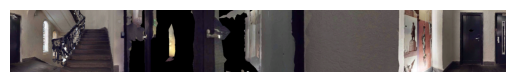

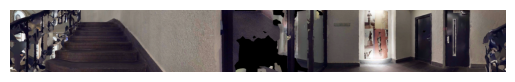

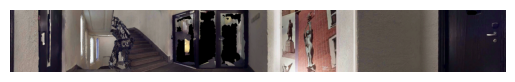

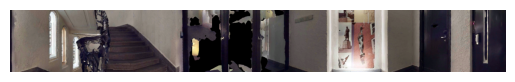

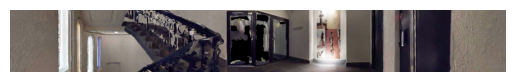

In [80]:
# split the frames such that each part has 4 images
split_frames = [vis_frames[i:i + 8] for i in range(0, len(vis_frames), 8)]

# flip the order of the images in each part
split_frames = [frames[::-1] for frames in split_frames]

# stitch the images in each part
panoramas = [stitch_images(frames) for frames in split_frames]

for i in range(min(len(panoramas), 10)):
    plt.imshow(panoramas[i])
    plt.axis("off")
    plt.show()

In [81]:
print(top_down_map.shape)


(970, 683, 3)


In [82]:
import numpy as np
from scipy.spatial import distance_matrix

def relative_neighborhood_graph(points):
    """
    Constructs a Relative Neighborhood Graph from a list of points.
    
    Parameters:
    points (list of tuples): List of (x, y) coordinates representing points on the topdown map.

    Returns:
    list of tuples: List of edges in the form of (point1, point2) where point1 and point2 are the coordinates of the points.
    """
    points = np.array(points)
    dist_matrix = distance_matrix(points, points)
    n = len(points)
    edges = []

    for i in range(n):
        for j in range(i + 1, n):
            edge_valid = True
            for k in range(n):
                if k != i and k != j:
                    if (dist_matrix[i][k] < dist_matrix[i][j] and dist_matrix[j][k] < dist_matrix[i][j]):
                        edge_valid = False
                        break
            if edge_valid:
                edges.append((tuple(points[i]), tuple(points[j])))
    
    return edges

# Example usage
edges = relative_neighborhood_graph(points)
print(edges)


[((325, 522), (288, 571)), ((246, 535), (288, 571)), ((330, 605), (288, 571)), ((288, 571), (244, 615))]


(970, 683, 3)


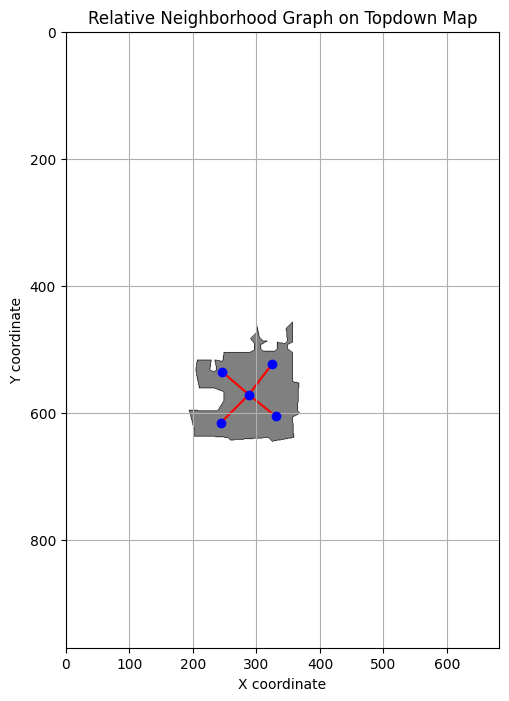

In [83]:
def visualize_rng_on_image(points, edges, img):
    """
    Visualizes the Relative Neighborhood Graph on top of a topdown map image.
    
    Parameters:
    points (list of tuples): List of (x, y) coordinates representing points on the topdown map.
    edges (list of tuples): List of edges in the form of (point1, point2).
    image_path (str): Path to the image file representing the topdown map.
    """
    # transform the image to numpy array
    img = np.array(img)
    print(img.shape)
    # Load the image
    plt.figure(figsize=(8, 8))
    plt.imshow(img, origin='upper')
    
    # Plot the points and edges
    points = np.array(points)
    plt.scatter(points[:, 0], points[:, 1], color='blue', zorder=2)
    
    for edge in edges:
        p1, p2 = edge
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='red', zorder=1)
    
    plt.title('Relative Neighborhood Graph on Topdown Map')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.grid(True)
    plt.show()


# Example usage
visualize_rng_on_image(points, edges, top_down_map)

(970, 683, 3)


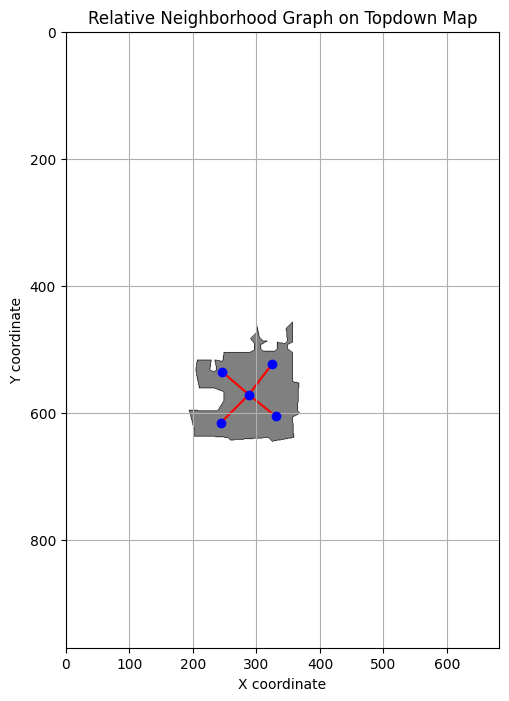

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from PIL import Image
from scipy.sparse.csgraph import connected_components
from scipy.spatial import KDTree

def edge_crosses_border(p1, p2, img_array):
    """
    Check if the edge between points p1 and p2 crosses a border in the image.
    
    Parameters:
    p1, p2 (tuple): Points representing the edge.
    img_array (np.array): Image array representing the topdown map.
    
    Returns:
    bool: True if the edge crosses a border, False otherwise.
    """
    x1, y1 = p1
    x2, y2 = p2
    x_values = np.linspace(x1, x2, 1000, dtype=int)
    y_values = np.linspace(y1, y2, 1000, dtype=int)
    
    for x, y in zip(x_values, y_values):
        if np.all(img_array[y, x] == [255, 255, 255]):
            return True
    return False

def remove_edges_crossing_borders(points, edges, img_array):
    """
    Remove edges that cross borders in the image.
    
    Parameters:
    points (list of tuples): List of (x, y) coordinates representing points on the topdown map.
    edges (list of tuples): List of edges in the form of (point1, point2).
    img_array (np.array): Image array representing the topdown map.
    
    Returns:
    list of tuples: List of edges after removing those crossing borders.
    """
    new_edges = []
    removed_edges = []
    for edge in edges:
        p1, p2 = edge
        if not edge_crosses_border(p1, p2, img_array):
            new_edges.append(edge)
        else:
            removed_edges.append(edge)
    return new_edges, removed_edges


def visualize_rng_on_image(points, edges, removed_edges, img):
    """
    Visualizes the Relative Neighborhood Graph on top of a topdown map image.
    
    Parameters:
    points (list of tuples): List of (x, y) coordinates representing points on the topdown map.
    edges (list of tuples): List of edges in the form of (point1, point2).
    image_path (str): Path to the image file representing the topdown map.
    """
    # transform the image to numpy array
    img = np.array(img)
    print(img.shape)
    # Load the image
    plt.figure(figsize=(8, 8))
    plt.imshow(img, origin='upper')
    
    # Plot the points and edges
    points = np.array(points)
    plt.scatter(points[:, 0], points[:, 1], color='blue', zorder=2)
    
    for edge in edges:
        p1, p2 = edge
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='red', zorder=1)
    
    for edge in removed_edges:
        p1, p2 = edge
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='red', zorder=1, linestyle='dashed')
    
    plt.title('Relative Neighborhood Graph on Topdown Map')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.grid(True)
    plt.show()

edges, removed_edges = remove_edges_crossing_borders(points, edges, top_down_map)
visualize_rng_on_image(points, edges, removed_edges, top_down_map)


In [88]:
# Create a set for quick lookup to avoid adding duplicate edges
edge_set = set(edges)

# Initialize a list to hold bidirectional edges
bidirectional_edges = edges.copy()

for start, end in edges:
    reversed_edge = (end, start)
    if reversed_edge not in edge_set:
        bidirectional_edges.append(reversed_edge)
        edge_set.add(reversed_edge)  # Add to set to avoid future duplicates


edges = bidirectional_edges

In [89]:
# Convert points to tuples
points = [tuple(point) for point in points]
# Convert edges to tuples of tuples
edges = [(tuple(start), tuple(end)) for start, end in edges]

## Populate Graph with Pre-Processed Images

In [90]:
import torch
import torchvision.transforms as transforms
from torchvision import models

def capture_pano(sim, pos):
    vis_frames = []  # List to store rendered frames
    point_3d = mn.Vector3(pos)
    agent_state.position = point_3d  # Set the agent's position

    # Compute initial north-facing orientation
    target_orientation_matrix = mn.Matrix4.look_at(
        point_3d, point_3d + mn.Vector3(0, 0, 1), mn.Vector3(0, 1, 0)
    )
    initial_orientation_q = mn.Quaternion.from_matrix(target_orientation_matrix.rotation())

    for rotation in [0, 45, 90, 135, 180, 225,  270, 315]:
    # for rotation in [0, 90, 180, 270]:
        rad = degrees_to_magnum_rad(rotation)  # Convert degrees to radians
        rotation_q = mn.Quaternion.rotation(rad, mn.Vector3(0, 1, 0))  # Rotate around the upward y-axis
        total_orientation_q = rotation_q * initial_orientation_q  # Apply the rotation

        # Convert the total orientation from Magnum to quaternion library format
        q = total_orientation_q
        agent_state.rotation = utils.quat_from_magnum(total_orientation_q)  # Set the agent's orientation

        agent.set_state(agent_state)  # Apply state to the agent

        # Capture sensor observations
        observations = sim.get_sensor_observations()
        rgb = observations["color_sensor"]
        vis_frames.append(rgb)

    images = vis_frames[::-1]
    panorama = stitch_images(images)[:, :, :3]
    
    return panorama

def preprocess_image(image, target_size=224):
    # Convert the image to a PIL image if it is a NumPy array
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    preprocess = transforms.Compose(
        [
            transforms.Resize(target_size),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    return preprocess(image).unsqueeze(0)

# Correct function to extract features
def extract_features_mobilenet_v3(image):
    input_tensor = preprocess_image(image)
    model = models.mobilenet_v3_large(pretrained=True)
    model.eval()
    with torch.no_grad():
        features = model.features(input_tensor)
    features_np = features.squeeze().cpu().numpy()
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    pooled_features = global_avg_pool(features).squeeze().cpu().numpy()
    return pooled_features

def rotate_omnidirectional_image(image, angle):
    height, width = image.shape[:2]
    shift = int((angle / 360.0) * width)
    rotated_image = np.roll(image, shift, axis=1)

    return rotated_image


def decode_rotation(rotated_image, original_image):
    height, width = original_image.shape[:2]
    for shift in range(width):
        if np.array_equal(rotated_image, np.roll(original_image, shift, axis=1)):
            angle = (shift / width) * 360.0
            return angle

    return None  

from collections import deque

def bfs_shortest_path(G, start, goal):
    if start not in G.nodes or goal not in G.nodes:
        return None

    queue = deque([(start, [start])])
    visited = set()

    while queue:
        current, path = queue.popleft()

        if current in visited:
            continue

        visited.add(current)

        for neighbor in G.neighbors(current):
            if neighbor in visited:
                continue
            if neighbor == goal:
                return path + [neighbor]

            queue.append((neighbor, path + [neighbor]))

    return None

def calculate_min_rotational_loss(current_view,  goal_features):
    min_error = 100
    best_angle = None
    for i in range(0,360): 
        current_angle_view = rotate_omnidirectional_image(current_view, i)
        current_features = extract_features_mobilenet_v3(current_angle_view)
        current_features = current_features / np.linalg.norm(current_features)
        goal_features = goal_features / np.linalg.norm(goal_features)
        error = 1 - np.dot(current_features, goal_features)
        if error < min_error:
            min_error = error
            best_angle = i
        
    return best_angle, min_error


# Helper function to calculate the angle between two nodes

def calculate_rotation(coord1, coord2):
    delta_x = coord2[0] - coord1[0]
    delta_y = coord2[1] - coord1[1]
    
    # Calculate angle with arctan2, considering north as 0 degrees
    angle = np.arctan2(delta_x, delta_y) * 180 / np.pi  # Note the order of delta_x and delta_y
    
    # Normalize to [0, 360) degrees
    normalized_angle = (angle + 360) % 360
    
    return normalized_angle

In [91]:
import networkx as nx

def create_graph_with_images(sim, nodes, edges, meters_per_pixel, sim_settings):
    G = nx.DiGraph()
    
    # Capture and store panoramic images at each node
    for node in nodes:
        coord_3d = convert_topdown_to_3d(sim.pathfinder, [node], meters_per_pixel, sim_settings["agent_height"])[0]
        agent = sim.get_agent(0)
        agent_state = agent.get_state()
        agent_state.position = coord_3d
        agent_state.position[1] = sim_settings["agent_height"]
        agent.set_state(agent_state)
        
        # Capture panoramic image at this node
        node_image = capture_pano(sim, agent.get_state().position)
        G.add_node(node, image=node_image)
    
    # Capture and store images for edges
    for edge in edges:
        start, end = edge
        angle = calculate_rotation(start, end)
        # Rotate start node image by the calculated angle
        edge_image = rotate_omnidirectional_image(G.nodes[start]['image'], angle)
        G.add_edge(start, end, image=edge_image)
    
    return G

# Example usage
# Assuming sim, nodes, edges, meters_per_pixel, and sim_settings are defined
G = create_graph_with_images(sim, points, edges, meters_per_pixel, sim_settings)

In [92]:

# def display_graph_images(G):
#     """
#     Displays each image stored in the graph's nodes and edges in the format:
#     1: NodeX: [image], 2: Edge from NodeX to NodeY: [image]
    
#     Parameters:
#     - G: The graph (networkx graph object) where node and edge images are stored as attributes.
#     """
#     count = 1
    
#     # Display node images
#     for node in G.nodes:
#         image = G.nodes[node].get('image')
#         if image is not None:
#             plt.imshow(image)
#             plt.title(f"{count}: Node {node}")
#             plt.axis("off")
#             plt.show()
#             count += 1
    
#     # Display edge images
#     for edge in G.edges:
#         image = G.edges[edge].get('image')
#         if image is not None:
#             plt.imshow(image)
#             plt.title(f"{count}: Edge from {edge[0]} to {edge[1]}")
#             plt.axis("off")
#             plt.show()
#             count += 1

# # Example usage
# # Assuming G is the graph with images stored as attributes
# display_graph_images(G)

In [93]:
def transform_graph_with_features(G):
    # Replace node images with feature vectors
    for node in G.nodes:
        image = G.nodes[node].get('image')
        if image is not None:
            features = extract_features_mobilenet_v3(image)
            G.nodes[node]['features'] = features
            # Optionally, you can remove the image if no longer needed
            del G.nodes[node]['image']
    
    # Replace edge images with feature vectors
    for edge in G.edges:
        image = G.edges[edge].get('image')
        if image is not None:
            features = extract_features_mobilenet_v3(image)
            G.edges[edge]['features'] = features
            # Optionally, you can remove the image if no longer needed
            del G.edges[edge]['image']
    
    return G

G = transform_graph_with_features(G)

/home/jack/miniconda3/envs/habitat/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jack/miniconda3/envs/habitat/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Generating Numerous Random Points, Capturing and Pre-Processing Images

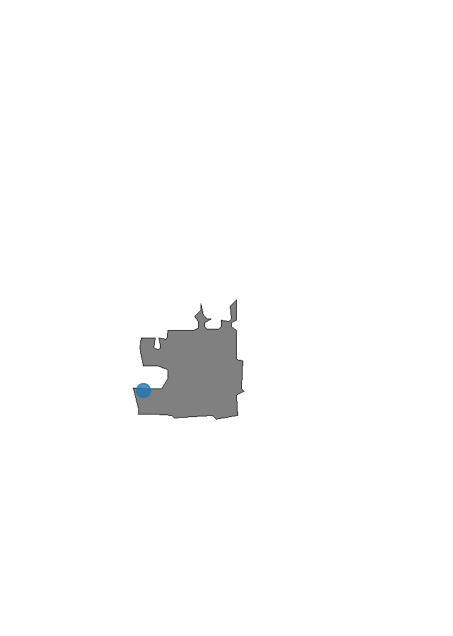

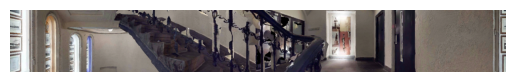

In [94]:

import numpy as np
import matplotlib.pyplot as plt
import habitat_sim
import magnum as mn

points_manager = PointsManager()
random_points = []
num_queries = 1 # number of random images 

while len(random_points) < num_queries:
    points_manager.generate_random_point(top_down_map.shape[0], top_down_map.shape[1])
    if top_down_map[points_manager.random_point[0], points_manager.random_point[1]][0] == 128:
        random_point = [points_manager.random_point[1], points_manager.random_point[0]] 
        random_points.append(random_point) 

display_map(top_down_map, key_points=random_points)

def degrees_to_magnum_rad(deg):
    return mn.Rad(deg * np.pi / 180.0)

random_panoramas = []

if not sim.pathfinder.is_loaded:
    print("Pathfinder not initialized, aborting.")
else:
    seed = 4  
    sim.pathfinder.seed(seed)

    scene_bb = sim.get_active_scene_graph().get_root_node().cumulative_bb

    display_path_agent_renders = True
    if display_path_agent_renders:
        agent_state = habitat_sim.AgentState()
        random_panoramas = [] 

        for point in random_points:
            vis_frames = [] 

            point_3d = convert_topdown_to_3d(sim.pathfinder, [point], meters_per_pixel, sim_settings["agent_height"])[0]
            point_3d = mn.Vector3(point_3d)
            agent_state.position = point_3d 

            target_orientation_matrix = mn.Matrix4.look_at(
                point_3d, point_3d + mn.Vector3(0, 0, 1), mn.Vector3(0, 1, 0)
            )
            initial_orientation_q = mn.Quaternion.from_matrix(target_orientation_matrix.rotation())

            for rotation in [0, 45, 90, 135, 180, 225, 270, 315]:
                rad = degrees_to_magnum_rad(rotation) 
                rotation_q = mn.Quaternion.rotation(rad, mn.Vector3(0, 1, 0))
                total_orientation_q = rotation_q * initial_orientation_q 

                q = total_orientation_q
                agent_state.rotation = utils.quat_from_magnum(total_orientation_q)

                agent.set_state(agent_state)

                observations = sim.get_sensor_observations()
                rgb = observations["color_sensor"]
                vis_frames.append(rgb)

            images = vis_frames[::-1]
            random_panorama = stitch_images(images)[:, :, :3]

            plt.imshow(random_panorama)
            plt.axis("off")
            plt.show()

            random_panoramas.append(random_panorama)


In [95]:
random_panoramas = [im[:, :, :3] for im in random_panoramas]
panoramas = [im[:, :, :3] for im in panoramas]

In [96]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

def image_to_feature_vector(image, kmeans_model):
    
    _, descriptors = extract_sift_features(image)
    
    if descriptors is not None:
        # Predict the nearest cluster each SIFT descriptor belongs to
        predicted_labels = kmeans_model.predict(descriptors)
        
        # Create histogram of features
        feature_vector = np.bincount(predicted_labels, minlength=kmeans_model.n_clusters)
        
        # Normalize the histogram to form the final feature vector
        feature_vector = feature_vector / np.linalg.norm(feature_vector)
        
        return feature_vector
    else:
        # Return a zero vector if no descriptors are found
        return np.zeros(kmeans_model.n_clusters)

panoramas_flat = []

pre_processing = "mobilenet_v3"  # @param ["mobilenet_v3", "SIFT"]

if pre_processing == "mobilenet_v3":
    for panorama in panoramas:
        image = Image.fromarray(panorama)
        # Step 3: Preprocess the image
        input_tensor = preprocess_image(image)

        # Step 4: Load pre-trained MobileNetV3 model
        model = models.mobilenet_v3_large(pretrained=True)
        model.eval()

        # Step 5: Extract features
        with torch.no_grad():
            features = model.features(input_tensor)

        # Step 6: Convert the feature maps to a numpy array and visualize
        features_np = features.squeeze().cpu().numpy()
        num_feature_maps = features_np.shape[0]

        # Step 8: Apply global average pooling
        global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        pooled_features = global_avg_pool(features).squeeze().cpu().numpy()

        panoramas_flat.append(pooled_features)

elif pre_processing == "SIFT":
    # Usage
    panoramas_flat = aggregate_descriptors(panoramas)
    kmeans_model = train_kmeans(panoramas_flat)

    # To visualize cluster centers as images (assuming SIFT descriptors of size 128)
    fig, axs = plt.subplots(5, 10, figsize=(20, 10))  # Adjust subplot grid size based on n_clusters
    for ax, center in zip(axs.flat, kmeans_model.cluster_centers_):
        ax.imshow(center.reshape(16, 8), cmap='hot')  # Reshape should be aligned with descriptor size
        ax.axis('off')
    plt.show()

random_panoramas_flat = []

if pre_processing == "mobilenet_v3":
    for panorama in random_panoramas:
        image = Image.fromarray(panorama)
        # Step 3: Preprocess the image
        input_tensor = preprocess_image(image)

        # Step 4: Load pre-trained MobileNetV3 model
        model = models.mobilenet_v3_large(pretrained=True)
        model.eval()

        # Step 5: Extract features
        with torch.no_grad():
            features = model.features(input_tensor)

        # Step 6: Convert the feature maps to a numpy array and visualize
        features_np = features.squeeze().cpu().numpy()
        num_feature_maps = features_np.shape[0]

        # Step 8: Apply global average pooling
        global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        pooled_features = global_avg_pool(features).squeeze().cpu().numpy()

        random_panoramas_flat.append(pooled_features)

elif pre_processing == "SIFT":
    feature_vectors = []
    for panorama in random_panoramas:
        random_panorama_flat = image_to_feature_vector(panorama, kmeans_model)
        feature_vectors.append(random_panorama_flat)
    
    # Convert the list of feature vectors to a numpy array
    random_panorama_features = np.array(feature_vectors)


## Testing ANN on Random Panoramas and Plotting Results on Topdown Map

In [97]:
# load all_panoramas.npy and all_envs.npy
all_panoramas = np.load("all_panoramas.npy")
all_envs = np.load("all_envs.npy")
all_coords = np.load("all_coords.npy")


Success rate for 1st neighbour in correct environment: 1.0
Success rate for any neighbour (first 10) in correct environment: 1.0


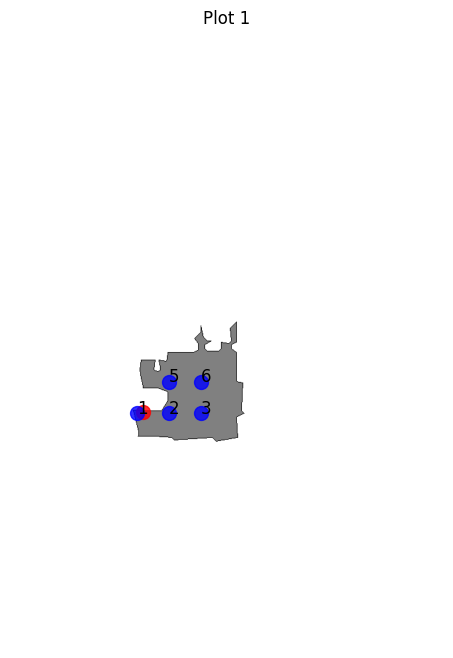

In [98]:
import numpy as np
import hnswlib
import matplotlib.pyplot as plt

# Utility functions
def extract_relevant_path(full_path):
    start_index = full_path.find("scene_datasets")
    return full_path[start_index:] if start_index != -1 else None

def are_paths_equivalent(path1, path2):
    relevant_path1 = extract_relevant_path(path1)
    relevant_path2 = extract_relevant_path(path2)
    return relevant_path1 == relevant_path2

# Parameters for HNSW
dim = all_panoramas.shape[1]  # Dimension of the feature vectors
num_elements = all_panoramas.shape[0]  # Number of panoramas
k = 10  # Number of neighbors to search for

# Initialize the HNSW index
p = hnswlib.Index(space='cosine', dim=dim)  # Using cosine distance

# Initialize the index with the number of elements and the maximum number of elements it can contain
p.init_index(max_elements=num_elements, ef_construction=200, M=16)

# Add the data points (panoramas) to the index
p.add_items(all_panoramas)

# Set the query time parameters
p.set_ef(50)  # ef should always be > k

# Iterate over each random panorama and find nearest neighbors
all_indices = []
all_distances = []
for idx, random_panorama_flat in enumerate(random_panoramas_flat):
    # Reshape and query the HNSW index
    indices, distances = p.knn_query(random_panorama_flat, k=k)
    all_indices.append(indices)
    all_distances.append(distances)


all_points = []
all_orders = []

for i, random_point in enumerate(random_points):
    point = np.array(random_points[i])
    neighbours = []
    order = []

    for j, index in enumerate(all_indices[i][0]):
        if are_paths_equivalent(all_envs[index], test_scene):
            neighbours.append(all_coords[index])
            order.append(j + 1)

    if neighbours:
        relevant_points = np.vstack((point, neighbours))
    else:
        relevant_points = point.reshape(1, -1)

    all_points.append(relevant_points)
    all_orders.append(order)


def is_within_threshold(arrays, threshold):
    results1 = []
    results2 = []
    for array in arrays:
        if len(array) < 2:
            results1.append(False)
            results2.append(False)
            continue
        else:
            results2.append(True)

        # Calculate the Euclidean distance between the first and second coordinates
        dist = np.linalg.norm(array[0] - array[1])
        results1.append(dist <= threshold)
    
    return results1, results2

def correct_env_success_rate(arrays):
    closest_nn_success_count = 0
    any_nn_success_count = 0
    total_count = 0

    for array in arrays:
        if len(array) > 0:
            if array[0] == 1:
                closest_nn_success_count += 1
            any_nn_success_count += 1
            total_count += 1

    if total_count == 0:
        return 0.0, 0.0

    closest_nn_success_rate = closest_nn_success_count / total_count
    any_nn_success_rate = any_nn_success_count / total_count
    return closest_nn_success_rate, any_nn_success_rate


# threshold = 50.0
# results = is_within_threshold(all_points, threshold)
# print(f'Within threshold: {np.mean(results[0])}')
# print(f'Any point checked: {np.mean(results[1])}')

closest_nn_success, any_nn_success = correct_env_success_rate(all_orders)
print(f'Success rate for 1st neighbour in correct environment: {closest_nn_success}')
print(f'Success rate for any neighbour (first 10) in correct environment: {any_nn_success}')


# Plot each set of points and their orders in separate plots
for idx, (vh_points, orders) in enumerate(zip(all_points, all_orders)):
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.axis("off")
    plt.imshow(top_down_map)

    if vh_points.size > 0:  # Ensure points array is not empty
        plt.plot(vh_points[0][0], vh_points[0][1], marker="o", markersize=10, alpha=0.8, color="red")  # First point in red
        for i, point in enumerate(vh_points[1:], start=1):
            plt.plot(point[0], point[1], marker="o", markersize=10, alpha=0.8, color="blue")  # Remaining points in blue
            if i - 1 < len(orders):
                plt.text(point[0], point[1], str(orders[i-1]), fontsize=12)  # Numbering the points

    plt.title(f"Plot {idx + 1}")
    plt.show()



## Testing the Visual Homing Methods on Random Points

In [99]:
# Collection of helper functions
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import KDTree
import magnum as mn
from scipy.spatial.transform import Rotation as R
import numpy as np
import random

# Find 4 nearest neighbours in 2D space
def find_nearest_neighbours_2d(point, points, num_neighbours=4):
    distances = np.linalg.norm(points - point, axis=1)
    nearest_indices = np.argsort(distances)[:num_neighbours]
    return points[nearest_indices]

# Check if the distance between coord1 and coord2 is within the given threshold.
def is_within_threshold(coord1, coord2, threshold):
    if isinstance(coord1[0], np.ndarray):
        coord1 = coord1[0] 
    coord2 = np.array(coord2)
    distance = np.linalg.norm(coord1 - coord2)
    return distance <= threshold

# Create pano from 4 images
def stitch_images(images):
    min_height = min(img.shape[0] for img in images)
    resized_images = [cv2.resize(img, (int(img.shape[1] * min_height / img.shape[0]), min_height)) for img in images]
    return np.hstack(resized_images)

# Initialize agent at a position given top-down coordiante
def initialize_agent_at_pos(sim, agent, topdown_coord, meters_per_pixel):
    """Initialize agent at a specific position given in top-down coordinates."""
    pathfinder = sim.pathfinder
    points_3d = convert_topdown_to_3d(pathfinder, [topdown_coord], meters_per_pixel, sim_settings["agent_height"])
    agent_position = points_3d[0]

    agent_state = habitat_sim.AgentState()
    agent_state.position = np.array(agent_position)
    agent.set_state(agent_state)

    return convert_points_to_topdown(pathfinder, [agent_state.position], meters_per_pixel)

# Capture a panoramic image by rotating the agent
def capture_pano(sim, pos):
    vis_frames = []  # List to store rendered frames
    point_3d = mn.Vector3(pos)
    agent_state.position = point_3d  # Set the agent's position

    # Compute initial north-facing orientation
    target_orientation_matrix = mn.Matrix4.look_at(
        point_3d, point_3d + mn.Vector3(0, 0, 1), mn.Vector3(0, 1, 0)
    )
    initial_orientation_q = mn.Quaternion.from_matrix(target_orientation_matrix.rotation())

    for rotation in [0, 45, 90, 135, 180, 225,  270, 315]:
    # for rotation in [0, 90, 180, 270]:
        rad = degrees_to_magnum_rad(rotation)  # Convert degrees to radians
        rotation_q = mn.Quaternion.rotation(rad, mn.Vector3(0, 1, 0))  # Rotate around the upward y-axis
        total_orientation_q = rotation_q * initial_orientation_q  # Apply the rotation

        # Convert the total orientation from Magnum to quaternion library format
        q = total_orientation_q
        agent_state.rotation = utils.quat_from_magnum(total_orientation_q)  # Set the agent's orientation

        agent.set_state(agent_state)  # Apply state to the agent

        # Capture sensor observations
        observations = sim.get_sensor_observations()
        rgb = observations["color_sensor"]
        vis_frames.append(rgb)

    images = vis_frames[::-1]
    panorama = stitch_images(images)[:, :, :3]
    
    return panorama

# Correct function to extract features
def extract_features_mobilenet_v3(image):
    input_tensor = preprocess_image(image)
    model = models.mobilenet_v3_large(pretrained=True)
    model.eval()
    with torch.no_grad():
        features = model.features(input_tensor)
    features_np = features.squeeze().cpu().numpy()
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    pooled_features = global_avg_pool(features).squeeze().cpu().numpy()
    return pooled_features

def find_nearest_neighbors(features, panoramas_flat):
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(panoramas_flat)
    distances, indices = neigh.kneighbors([features])
    return indices, distances


def calculate_loss(current_position, target_view):
    pano = capture_pano(sim, current_position)
    current_view = extract_features_mobilenet_v3(pano)
    current_view = current_view / np.linalg.norm(current_view)
    target_view = target_view / np.linalg.norm(target_view)
    error = 1 - np.dot(current_view, target_view)
    return error

def random_direction():
    return random.choice([0, 45, 90, 135, 180, 225, 270, 315])

def move_agent(sim, agent, point, direction, step_size):
    agent_state = habitat_sim.AgentState()
    agent_state.position = point 

    # Set agent to face forward (north)
    target_orientation_matrix = mn.Matrix4.look_at(
        point, point + mn.Vector3(0, 0, 1), mn.Vector3(0, 1, 0)
    )
    forward_orientation_q = mn.Quaternion.from_matrix(target_orientation_matrix.rotation())
    agent_state.rotation = utils.quat_from_magnum(forward_orientation_q)
    agent.set_state(agent_state)

    # Adjust the agent's orientation to the desired direction
    rad = degrees_to_magnum_rad(direction)
    rotation_q = mn.Quaternion.rotation(rad, mn.Vector3(0, 1, 0))
    total_orientation_q = rotation_q * forward_orientation_q
    agent_state.rotation = utils.quat_from_magnum(total_orientation_q)
    agent.set_state(agent_state)

    for _ in range(step_size):
        sim.step("move_forward")
    
    # Reset agent height after movement (Bug to fix)
    agent_state = agent.get_state()
    agent_state.position[1] = sim_settings["agent_height"]
    agent.set_state(agent_state)

def preprocess_image(image, target_size=224):
    # Convert the image to a PIL image if it is a NumPy array
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    preprocess = transforms.Compose(
        [
            transforms.Resize(target_size),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    return preprocess(image).unsqueeze(0)

In [100]:
def agent_walk1(sim, agent, starting_point, target_image_features):
    starting_point_2d = convert_points_to_topdown(sim.pathfinder, [starting_point], meters_per_pixel)[0]
    path = [starting_point_2d]
    starting_error = calculate_loss(starting_point, target_image_features)
    min_error = starting_error
    best_position = starting_point
    best_error = starting_error
    errors = [starting_error]
    agent = sim.get_agent(0)

    direction_angle = np.random.uniform(0, 360)
    step_size = 1
    upper_threshold = 0.005
    lower_threshold = 0.003
    fine_adjustment_threshold = 0.01
    max_step_size = 3
    min_step_size = 1
    max_iterations = 40

    num_moves = 0

    i = 0
    while i < max_iterations:
        i += 1

        current_position = agent.get_state().position
        move_agent(sim, agent, current_position, direction_angle, step_size)
        num_moves += 1
        new_position = agent.get_state().position
        path.append(convert_points_to_topdown(sim.pathfinder, [new_position], meters_per_pixel)[0])
        error = calculate_loss(new_position, target_image_features)

        # print(f"Error {error} at position {new_position} for step {i}")
        errors.append(error)

        if error < lower_threshold:
            # print('Finish Movements')
            break

        # Fine adjustment mode when close to target
        if error < fine_adjustment_threshold:
            direction_angle += np.random.uniform(-5, 5)  # Smaller random perturbation for fine adjustment

        # Calculate error gradient
        gradient = error - errors[-2]

        if gradient > 0:
            # If error increased, revert to previous best position
            agent_state = agent.get_state()
            agent_state.position = best_position
            agent.set_state(agent_state)
            direction_angle += 90  # Rotate by 90 degrees to explore a different direction
            step_size = min_step_size  # Reset step size to minimum after reverting
        else:
            # If error decreased, update best position
            if error < best_error:
                best_error = error
                best_position = new_position

            # Continue in the same direction with small adjustments
            direction_angle += np.random.uniform(-10, 10)  # Small random perturbation

        if error < upper_threshold:
            step_size = min_step_size
        else:
            # Adjust step size dynamically based on error change
            if gradient < 0:  # If the error is decreasing
                step_size = max(step_size - 1, min_step_size)
            else:  # If the error is increasing
                step_size = min(step_size + 1, max_step_size)

        # Ensure direction_angle stays within 0 to 360 degrees
        direction_angle = direction_angle % 360

        # Early stopping if no significant improvement
        if len(errors) > 5 and abs(errors[-1] - errors[-5]) < 1e-4:
            # print("Early stopping due to lack of significant improvement.")
            break

        # Update minimum error
        if error < min_error:
            min_error = error

    return path, errors, num_moves

In [101]:
# Plotting points without the topdown
simulation_distance =  meters_per_pixel

def display_points(key_points, simulation_distance):
    plt.figure(figsize=(10, 8))  # Adjust figure size as needed
    ax = plt.subplot(1, 1, 1)
   
    # Plot points without map
    if key_points is not None:
        for i, point in enumerate(key_points):
            if i == 0:
                plt.plot(point[0], point[1], marker="o", markersize=14, alpha=0.8, color='red')
                plt.text(point[0], point[1], 'R', color='black', fontsize=14, ha='center', va='center')
            elif i == len(key_points) - 1:
                plt.plot(point[0], point[1], marker="o", markersize=14, alpha=0.8, color='red')
                plt.text(point[0], point[1], 'N', color='black', fontsize=14, ha='center', va='center')
            else:
                plt.plot(point[0], point[1], marker="o", markersize=12, alpha=0.8, color='blue')
                plt.text(point[0], point[1], str(i), color='white', fontsize=10, ha='center', va='center')

    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
   
    plt.title('Key Points Plot', fontsize=20)
    plt.xlabel('X Coordinate', fontsize=14)
    plt.ylabel('Y Coordinate', fontsize=14)

    plt.text(0.99, 0.00, f'{simulation_distance:.2f} meters between points',
             horizontalalignment='right', verticalalignment='bottom',
             transform=ax.transAxes, fontsize=12, color='red')
   
    plt.grid(True)  # Add a grid for better visibility
    plt.show()

1/1
Method 1 fail for nn: [200 600] and final routing point: [200 600]
path1


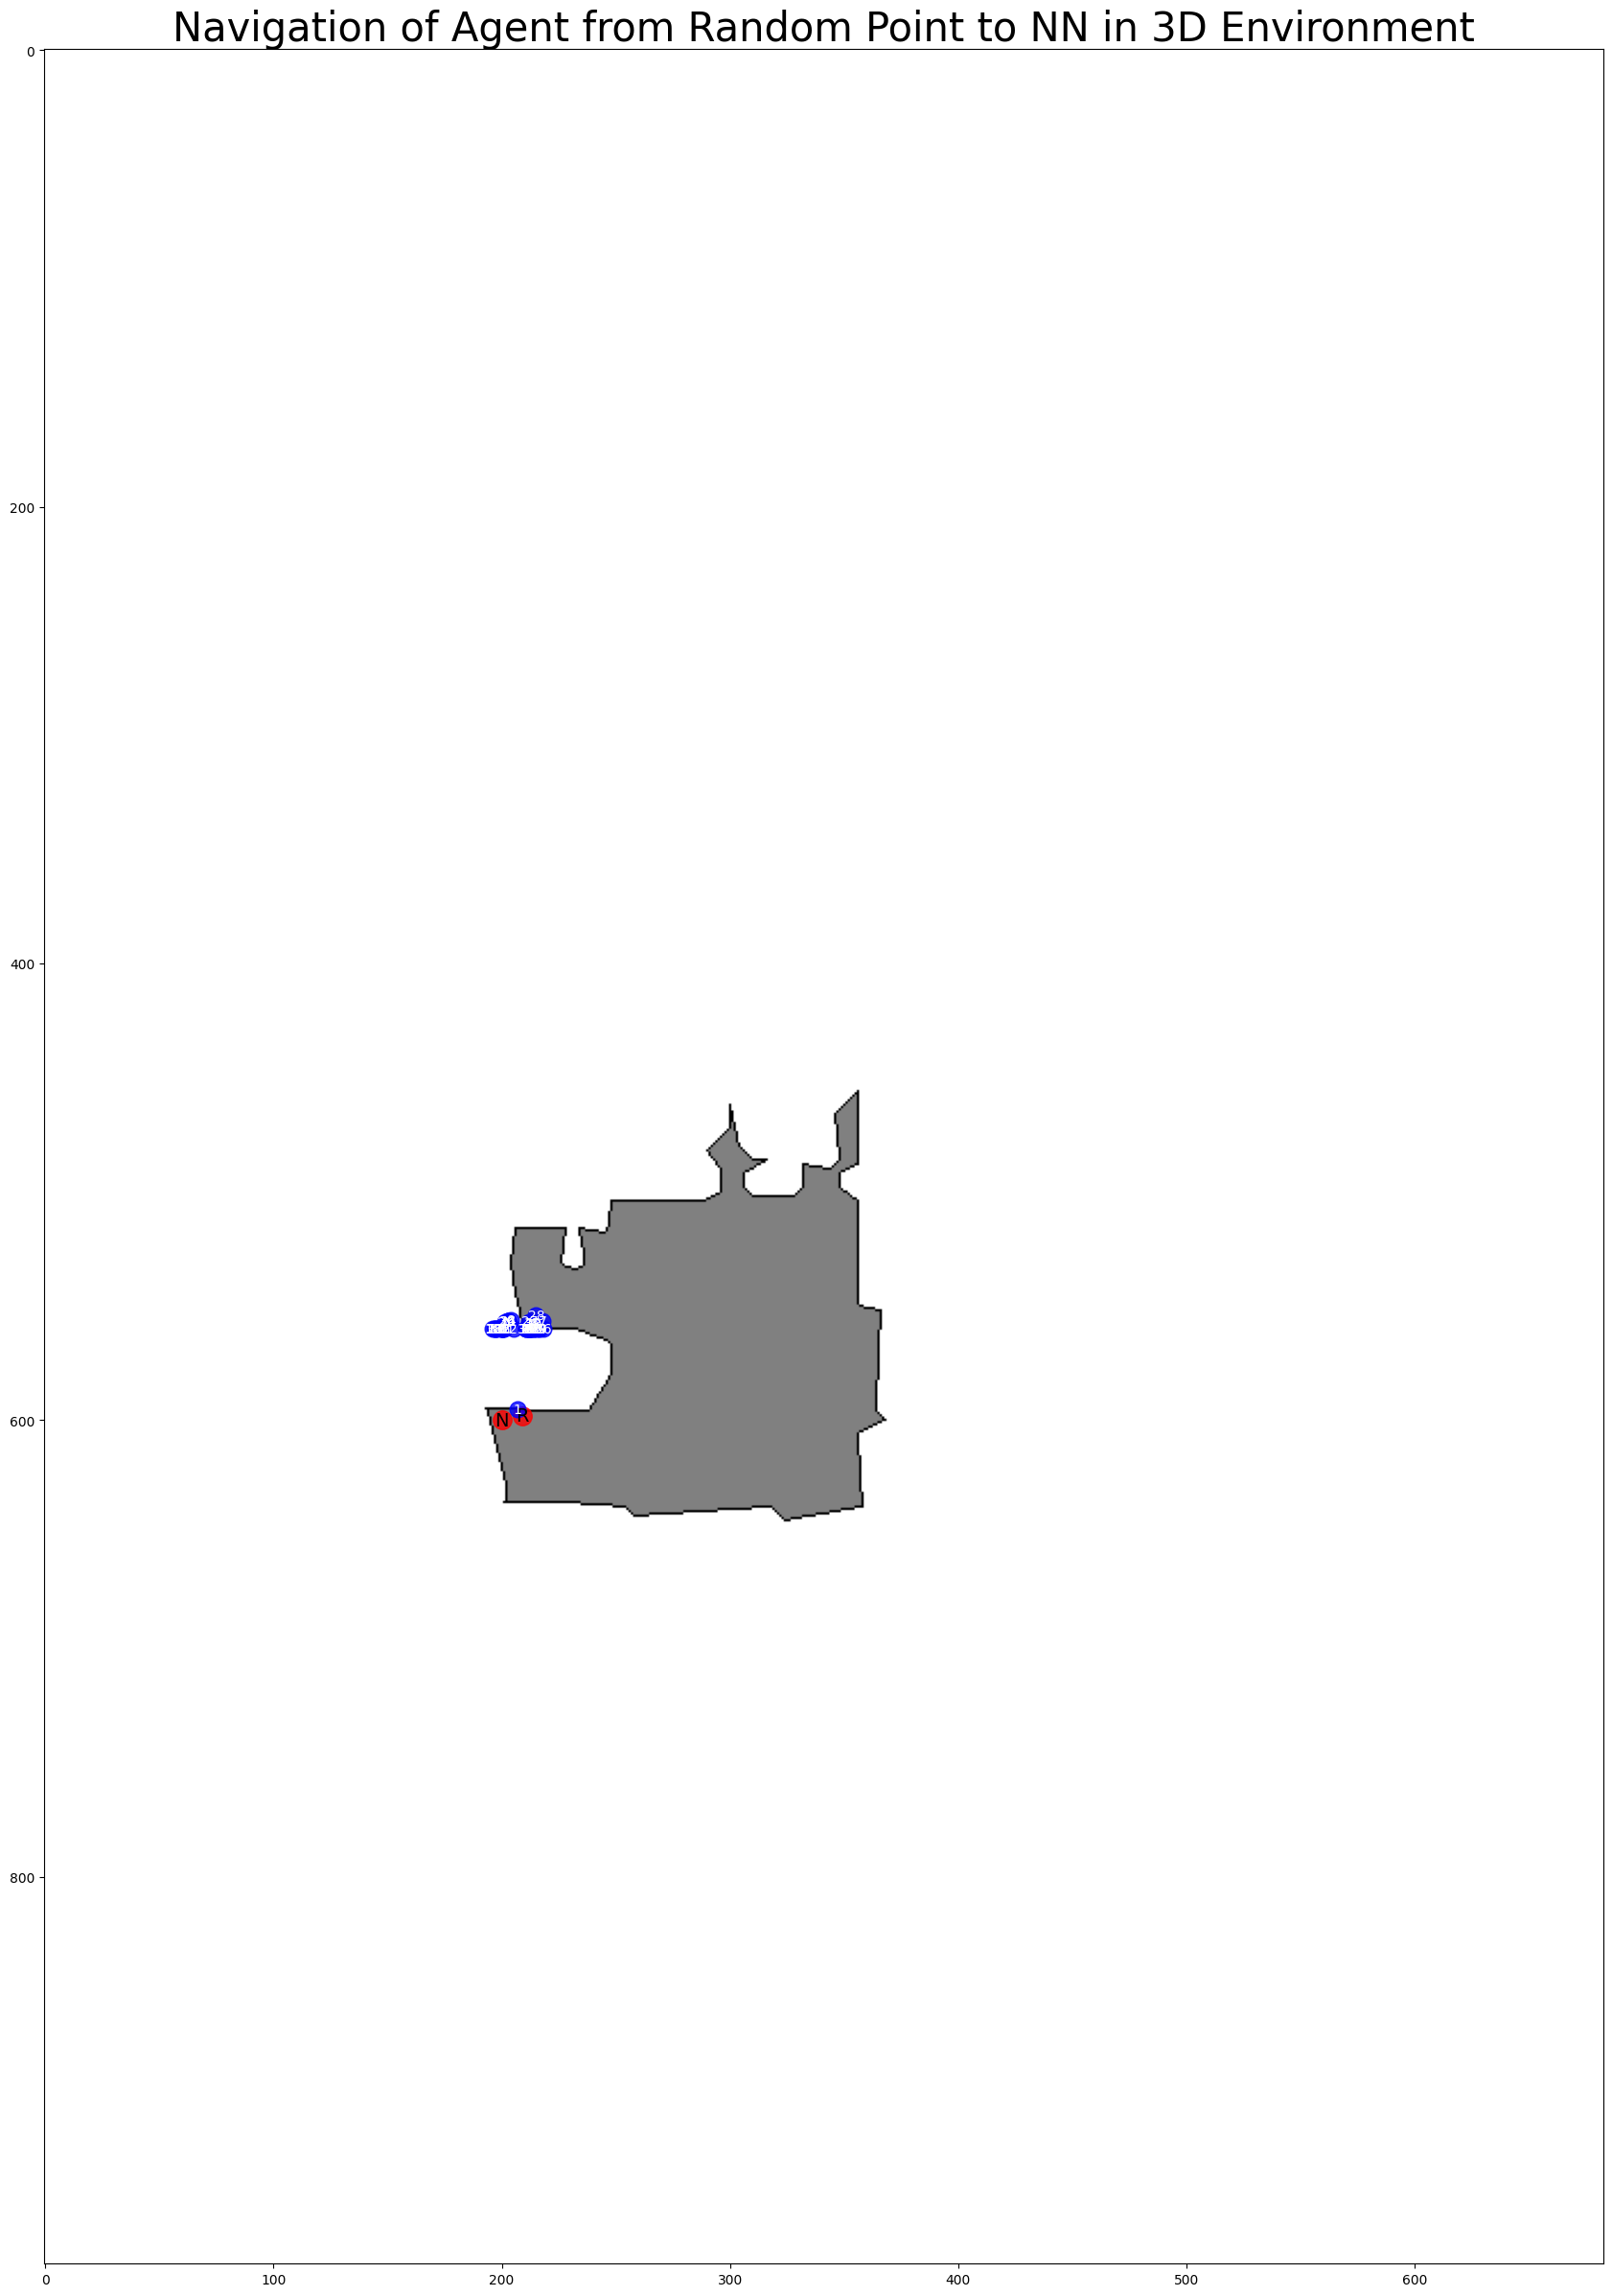

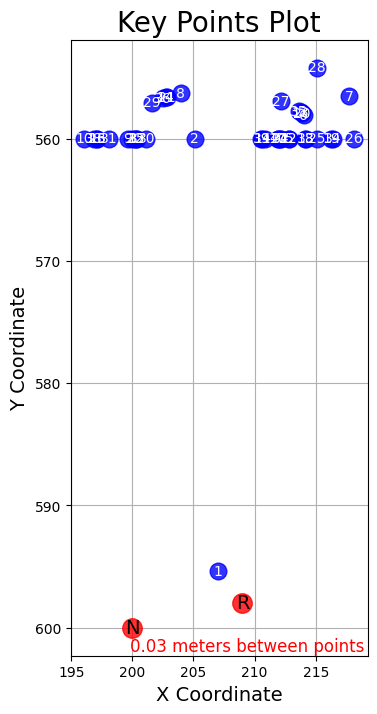


---------- Method 1 results ----------
Percentage of successful attempts: 0.0
Average distance from target: 41.72799891132529
Average number of moves: 40.0


In [102]:
nn_success = 0
walk1_success = 0
walk2_success = 0
walk3_success = 0
accuracy1 = 0
accuracy2 = 0
accuracy3 = 0
moves1 = 0
moves2 = 0 
moves3 = 0 


images_flat = []
for panorama in panoramas:
    image = Image.fromarray(panorama)
    features = extract_features_mobilenet_v3(image)
    images_flat.append(features)

i = 0
for point in random_points:
    print(f'{i + 1}/{len(random_points)}')

    coord_3d = convert_topdown_to_3d(sim.pathfinder, [point], meters_per_pixel, sim_settings["agent_height"])[0]
    
    agent = sim.get_agent(0)
    agent_state = agent.get_state()
    
    # Set initial state
    agent_state.position = mn.Vector3(coord_3d)
    agent.set_state(agent_state)
    agent_state = agent.get_state()
    agent_state.position[1] = sim_settings["agent_height"]
    agent.set_state(agent_state)
    
    
    if len(all_points[i]) > 1 :


        nn_success += 1
        path1, errors1, num_moves1 = agent_walk1(sim, agent, coord_3d, all_panoramas[all_indices[i][0][0]])
        path1.append(all_points[i][1])

        success1 = is_within_threshold(path1[-2], all_points[i][1], 2)

        accuracy1 += np.linalg.norm(path1[-2] - all_points[i][1])

        moves1 += num_moves1
       
        if success1:
            walk1_success += 1
        else: 
            print(f'Method 1 fail for nn: {all_points[i][1]} and final routing point: {path1[-1]}')
        
        print('path1')
        display_map_path(top_down_map, key_points=path1)
        display_points(path1, simulation_distance)
     
    i += 1

routing1_success = walk1_success / len(random_points)
routing1_moves = moves1/ len(random_points)
routing1_accuracy = accuracy1/len(random_points)


print('')
print('---------- Method 1 results ----------')
print(f"Percentage of successful attempts: {routing1_success}")
print(f"Average distance from target: {routing1_accuracy}")
print(f"Average number of moves: {routing1_moves}")

## Agent Navigation Along the Graph

In [103]:
def navigate_using_graph(sim, agent, current_position, path, G, meters_per_pixel):
    agent_moves = [convert_points_to_topdown(sim.pathfinder, [agent.get_state().position], meters_per_pixel)[0]]

    for i in range(len(path) - 1):
        current_node = path[i]
        next_node = path[i + 1]

        # Find the edge features for the direction
        if G.has_edge(current_node, next_node):
            edge_features = G.edges[current_node, next_node]['features']
        else:
            print(f"No edge found between {current_node} and {next_node}")
            return agent_moves

        # Get the features of the next node
        if G.has_node(next_node):
            next_node_features = G.nodes[next_node].get('features')
        else:
            print(f"Next node {next_node} does not exist in the graph.")
            return agent_moves
        
        current_view = capture_pano(sim, agent.get_state().position)
        
        # Calculate the direction to move
        direction, angle_error = calculate_min_rotational_loss(current_view, edge_features)

        if direction is None:
            print(f"Cannot decode direction from {current_node} to {next_node}")
            return agent_moves
        else:
            print(f"Direction: {direction}, Error: {angle_error}")
            # direction = (direction + 180)%360
        
        error = float('inf')
        prev_error = float('inf')
        j = 0
        print(f"Moving from {current_node} to {next_node}: Current position {convert_points_to_topdown(sim.pathfinder, [agent.get_state().position], meters_per_pixel)[0]}, Error {error}")
        while error >= 0.01 and j < 20:
            current_position = agent.get_state().position
            move_agent(sim, agent, current_position, direction, 1)
            agent_moves.append(convert_points_to_topdown(sim.pathfinder, [agent.get_state().position], meters_per_pixel)[0])
            prev_error = error
            error = calculate_loss(agent.get_state().position, next_node_features)
            print(f"Moving from {current_node} to {next_node}: Current position {convert_points_to_topdown(sim.pathfinder, [agent.get_state().position], meters_per_pixel)[0]}, Error {error}")
            j += 1
            if error < 0.1 and error > prev_error:
                move_agent(sim, agent, current_position, (direction + 180)%360, 1)
                print(f"Moving back from {current_node} to {next_node}: Current position {convert_points_to_topdown(sim.pathfinder, [agent.get_state().position], meters_per_pixel)[0]}, Error {error}")
                break

    return agent_moves


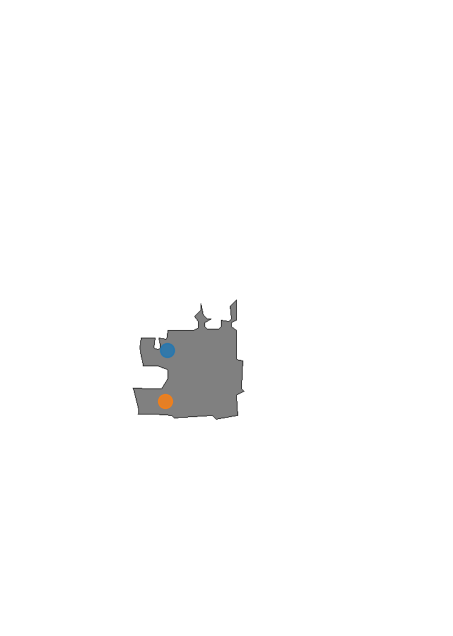

In [104]:
display_map(top_down_map, [points[1], points[4]])

Shortest path: [(246, 535), (288, 571), (244, 615)]


Direction: 50, Error: 0.02458488941192627
Moving from (246, 535) to (288, 571): Current position [246.00000381 535.        ], Error inf
Moving from (246, 535) to (288, 571): Current position [249.06417847 537.5711441 ], Error 0.325153648853302
Moving from (246, 535) to (288, 571): Current position [252.12835312 540.14228821], Error 0.27797287702560425
Moving from (246, 535) to (288, 571): Current position [255.19252777 542.71343231], Error 0.23130977153778076
Moving from (246, 535) to (288, 571): Current position [258.25670242 545.28461456], Error 0.22405213117599487
Moving from (246, 535) to (288, 571): Current position [261.32087708 547.85575867], Error 0.19075816869735718
Moving from (246, 535) to (288, 571): Current position [264.3850708  550.42690277], Error 0.14570915699005127
Moving from (246, 535) to (288, 571): Current position [267.44924545 552.99804688], Error 0.17363059520721436
Moving from (246, 535) to (288, 571): Current position [270.5134201  555.56919098], Error 0.1595

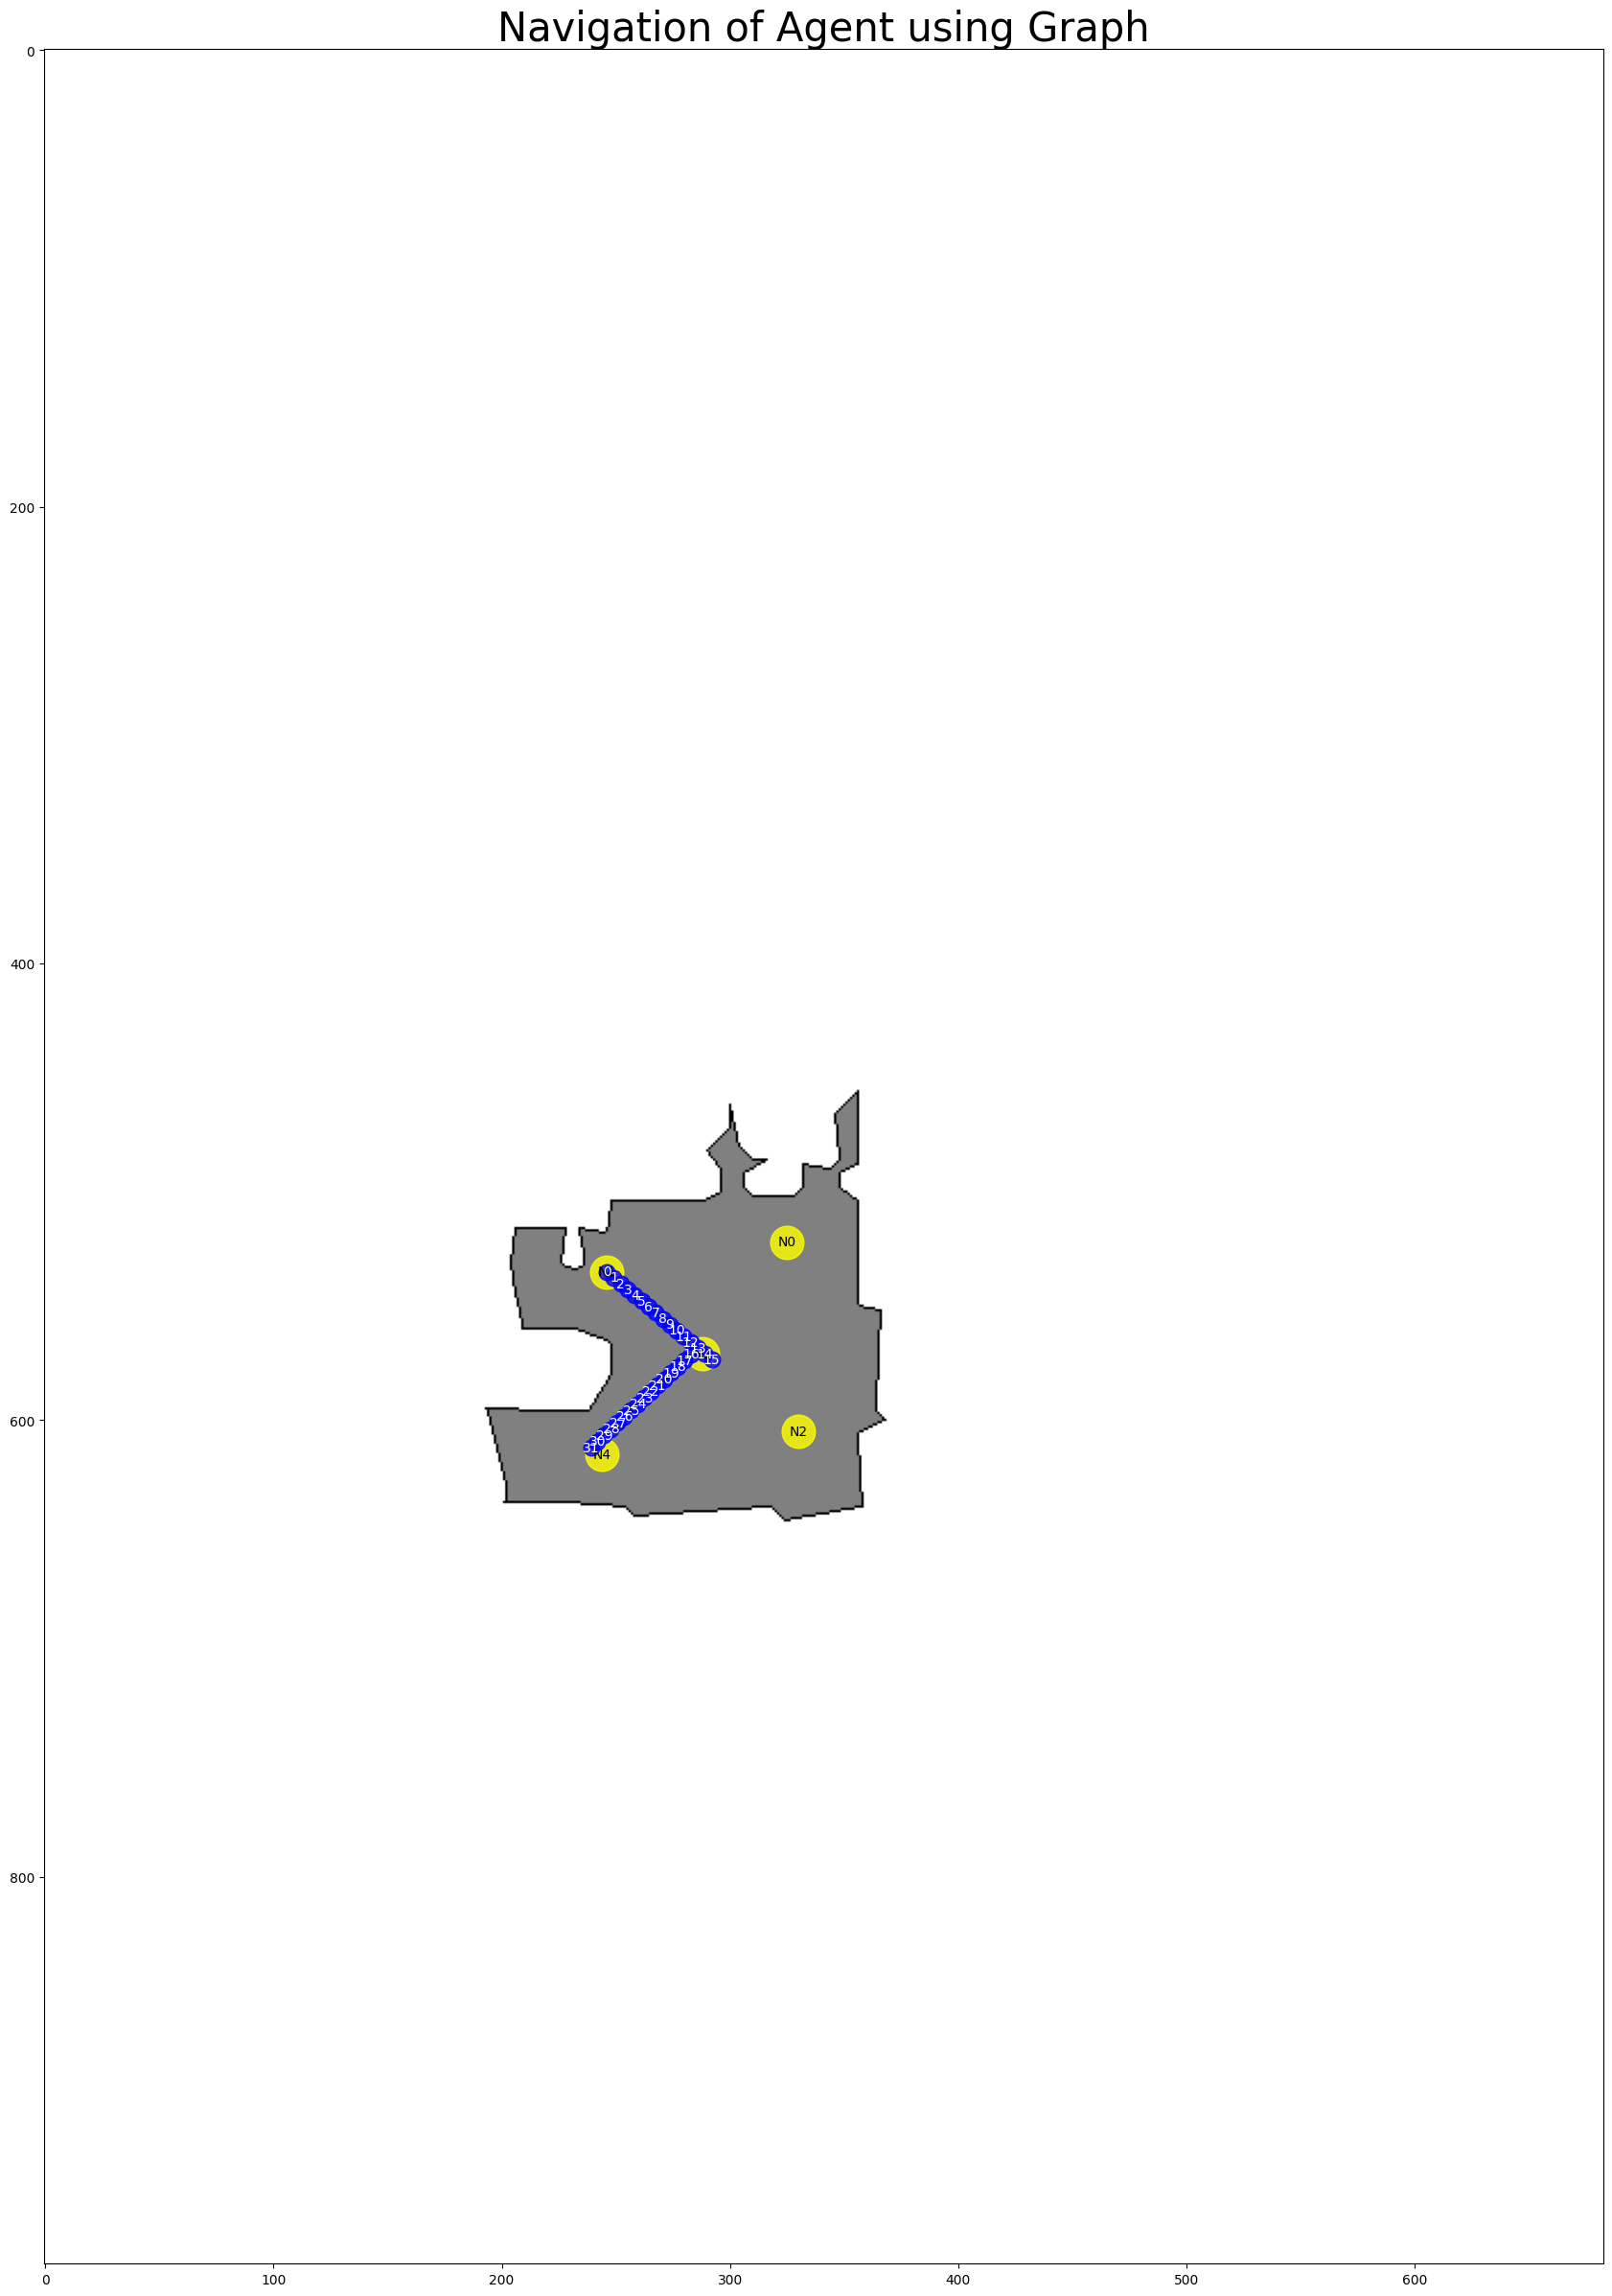

In [105]:
coord_3d = convert_topdown_to_3d(sim.pathfinder, [points[1]], meters_per_pixel, sim_settings["agent_height"])[0]
agent = sim.get_agent(0)
agent_state = agent.get_state()
agent_state.position = mn.Vector3(coord_3d)
agent.set_state(agent_state)
agent_state = agent.get_state()
agent_state.position[1] = sim_settings["agent_height"]
agent.set_state(agent_state)

start_node = points[1]
goal_node =  points[4]

path = bfs_shortest_path(G, start_node, goal_node)
print("Shortest path:", path)

agent_moves = navigate_using_graph(sim, agent, agent.get_state().position, path, G, meters_per_pixel)

display_graph_navigation(top_down_map, points, agent_moves)

A good question is whether, when calculating the next direction you should use current image or the original node image, as you will get 100% the right direction from the original node, you may be a tad off, otherwise you r direction may be wrong. 

## The full process

1. Pick two random points, capture panos, extract features. 

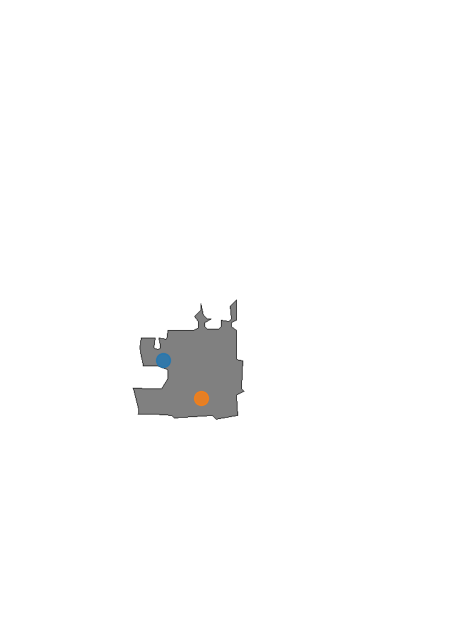

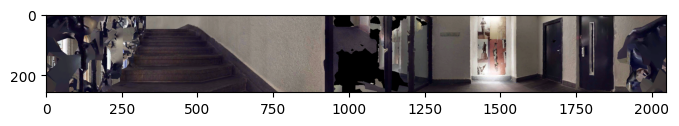

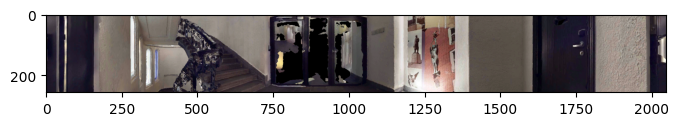

In [106]:
# Pick two random points with neighbours that are connected points due to graph builder not being fully complete 
random_points = [[240, 550], [300, 610]]

display_map(top_down_map, key_points=random_points)

random_panoramas = []

for point in random_points:

    coord_3d = convert_topdown_to_3d(sim.pathfinder, [point], meters_per_pixel, sim_settings["agent_height"])[0]
    
    agent = sim.get_agent(0)
    agent_state = agent.get_state()
    agent_state.position = mn.Vector3(coord_3d)
    agent.set_state(agent_state)
    agent_state = agent.get_state()
    agent_state.position[1] = sim_settings["agent_height"]
    agent.set_state(agent_state)

    pano = capture_pano(sim, agent.get_state().position)

    img = np.array(pano)
    plt.figure(figsize=(8, 8))
    plt.imshow(img, origin='upper')

    random_panoramas.append(pano)
    

random_panoramas = [im[:, :, :3] for im in random_panoramas]

random_panoramas_flat = []

for pano in random_panoramas:
    pano_features = extract_features_mobilenet_v3(pano)
    random_panoramas_flat.append(pano_features)

2. Find ANN of random points 

In [107]:
import hnswlib
import numpy as np

def build_hnsw_index_from_graph(graph):
    # Extract all node images and their node keys (identifiers)
    node_keys = []
    all_images = []
    
    for node in graph.nodes:
        image = graph.nodes[node]['features']  # Assuming 'image' stores the flattened MobileNet features
        node_keys.append(node)
        all_images.append(image)
    
    all_images = np.array(all_images)
    dim = all_images.shape[1]
    num_elements = all_images.shape[0]
    
    # Initialize the HNSW index
    p = hnswlib.Index(space='cosine', dim=dim)
    p.init_index(max_elements=num_elements, ef_construction=200, M=16)
    
    # Add the node images to the index
    p.add_items(all_images)
    p.set_ef(50)  # Set the query time parameters
    
    return p, node_keys

def find_nearest_neighbors(graph, hnsw_index, query_image, k=10):
    # Query the HNSW index to find the nearest neighbors
    indices, distances = hnsw_index.knn_query(query_image, k=k)
    
    # Map indices back to node keys
    nearest_nodes = [node_keys[idx] for idx in indices[0]]
    
    return nearest_nodes, distances[0]

# Assuming G is your DiGraph with nodes storing flattened MobileNet features
hnsw_index, node_keys = build_hnsw_index_from_graph(G)

all_nodes = []
all_distances = []

for random_panorama_flat in random_panoramas_flat:
    nearest_nodes, distances = find_nearest_neighbors(G, hnsw_index, random_panorama_flat, 3)
    all_nodes.append(nearest_nodes)
    all_distances.append(distances)
print(f"The nearest nodes are: {all_nodes}")
print(f"Corresponding distances are: {all_distances}")


The nearest nodes are: [[(246, 535), (288, 571), (244, 615)], [(244, 615), (288, 571), (330, 605)]]
Corresponding distances are: [array([0.1480478 , 0.23540777, 0.31109416], dtype=float32), array([0.1730445 , 0.17750621, 0.21491116], dtype=float32)]


3. Search for nodes in graph using ANN panos and then generate path. 

In [108]:
nn1 = all_nodes[0][0]
nn2 = all_nodes[1][0]

print(f"Nearest Neighbour 1: {nn1}")
print(f"Nearest Neighbour 2: {nn2}")

path = bfs_shortest_path(G, nn1, nn2)
print(f"Path from NN1 to NN2: {path}")

Nearest Neighbour 1: (246, 535)
Nearest Neighbour 2: (244, 615)
Path from NN1 to NN2: [(246, 535), (288, 571), (244, 615)]


4. Call agent walk from R1 to N1
5. Call navigate using graph for N1 to N2
6. Call agent walk from N2 to R2

In [113]:
coord_3d = convert_topdown_to_3d(sim.pathfinder, [random_points[0]], meters_per_pixel, sim_settings["agent_height"])[0]
agent = sim.get_agent(0)
agent_state = agent.get_state()
agent_state.position = mn.Vector3(coord_3d)
agent.set_state(agent_state)
agent_state = agent.get_state()
agent_state.position[1] = sim_settings["agent_height"]
agent.set_state(agent_state)

path1, errors1, num_moves1 = agent_walk1(sim, agent, agent.get_state().position, G.nodes[all_nodes[1][0]]['features'])

path2 = navigate_using_graph(sim, agent, agent.get_state().position, path, G, meters_per_pixel)

path3, errors3, num_moves3 = agent_walk1(sim, agent, agent.get_state().position, random_panoramas_flat[1])

/home/jack/miniconda3/envs/habitat/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jack/miniconda3/envs/habitat/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Direction: 180, Error: 0.2884713411331177
Moving from (246, 535) to (288, 571): Current position [255.72668076 608.59161377], Error inf
Moving from (246, 535) to (288, 571): Current position [255.72668076 604.59159851], Error 0.14668643474578857
Moving from (246, 535) to (288, 571): Current position [255.72668076 600.59158325], Error 0.13015854358673096
Moving from (246, 535) to (288, 571): Current position [255.72668076 596.59160614], Error 0.13368678092956543
Moving from (246, 535) to (288, 571): Current position [255.72668076 592.59159088], Error 0.12716645002365112
Moving from (246, 535) to (288, 571): Current position [255.72668076 588.59157562], Error 0.11580514907836914
Moving from (246, 535) to (288, 571): Current position [255.72668076 584.59159851], Error 0.11156052350997925
Moving from (246, 535) to (288, 571): Current position [255.72668076 580.59158325], Error 0.10612523555755615
Moving from (246, 535) to (288, 571): Current position [255.72668076 576.59156799], Error 0.10

Plotting results

In [122]:
def display_graph_navigation(topdown_map, graph_coords, random_points, movement1_coords, movement2_coords, movement3_coords):
    plt.figure(figsize=(40, 30))  # Increased figure size
    ax = plt.subplot(1, 1, 1)
    # ax.axis("off")
    plt.imshow(topdown_map)
    # plot points on map
    for i, point in enumerate(graph_coords):
            plt.plot(
                point[0],
                point[1],
                marker="o",
                markersize=25,
                alpha=0.8,
                color="green",
            )
            plt.text(
                point[0],
                point[1],
                str(f'N{i}'),
                color="black",
                fontsize=10,
                ha="center",
                va="center",
            )
    if movement1_coords is not None:
        for i, point in enumerate(movement1_coords):
            plt.plot(
                point[0],
                point[1],
                marker="o",
                markersize=12,
                alpha=0.8,
                color="blue",
            )
            plt.text(
                point[0],
                point[1],
                str(f"1.{i}"),
                color="white",
                fontsize=10,
                ha="center",
                va="center",
            )
    if movement2_coords is not None:
        for i, point in enumerate(movement2_coords):
            plt.plot(
                point[0],
                point[1],
                marker="o",
                markersize=12,
                alpha=0.8,
                color="blue",
            )
            plt.text(
                point[0],
                point[1],
                str(f"2.{i}"),
                color="white",
                fontsize=10,
                ha="center",
                va="center",
            )
    if movement3_coords is not None:
        for i, point in enumerate(movement3_coords):
            plt.plot(
                point[0],
                point[1],
                marker="o",
                markersize=12,
                alpha=0.8,
                color="blue",
            )
            plt.text(
                point[0],
                point[1],
                str(f"3.{i}"),
                color="white",
                fontsize=10,
                ha="center",
                va="center",
            )
    if random_points is not None:
        for i, point in enumerate(random_points):
            plt.plot(
                point[0],
                point[1],
                marker="o",
                markersize=12,
                alpha=0.8,
                color="red",
            )
            plt.text(
                point[0],
                point[1],
                str({i}),
                color="white",
                fontsize=10,
                ha="center",
                va="center",
            )
    plt.title(
        "Navigation of Agent using Graph", fontsize=30
    )
    plt.show(block=False)

def display_graph_navigation_before_agent_movement(topdown_map, graph_coords, random_points, nearest_neighbours_and_path):
    plt.figure(figsize=(40, 30))  # Increased figure size
    ax = plt.subplot(1, 1, 1)
    # ax.axis("off")
    plt.imshow(topdown_map)
    # plot points on map
    for i, point in enumerate(graph_coords):
            plt.plot(
                point[0],
                point[1],
                marker="o",
                markersize=25,
                alpha=0.8,
                color="green",
            )
            plt.text(
                point[0],
                point[1],
                str(f'N{i}'),
                color="black",
                fontsize=10,
                ha="center",
                va="center",
            )
    if nearest_neighbours_and_path is not None:
        for i, point in enumerate(nearest_neighbours_and_path):
            plt.plot(
                point[0],
                point[1],
                marker="o",
                markersize=25,
                alpha= 1,
                color="blue",
            )
            plt.text(
                point[0],
                point[1],
                str(f"1.{i}"),
                color="white",
                fontsize=10,
                ha="center",
                va="center",
            )
    if random_points is not None:
        for i, point in enumerate(random_points):
            plt.plot(
                point[0],
                point[1],
                marker="o",
                markersize=12,
                alpha=0.8,
                color="red",
            )
            plt.text(
                point[0],
                point[1],
                str({i}),
                color="white",
                fontsize=10,
                ha="center",
                va="center",
            )
    plt.title(
        "Navigation of Agent using Graph", fontsize=30
    )
    plt.show(block=False)

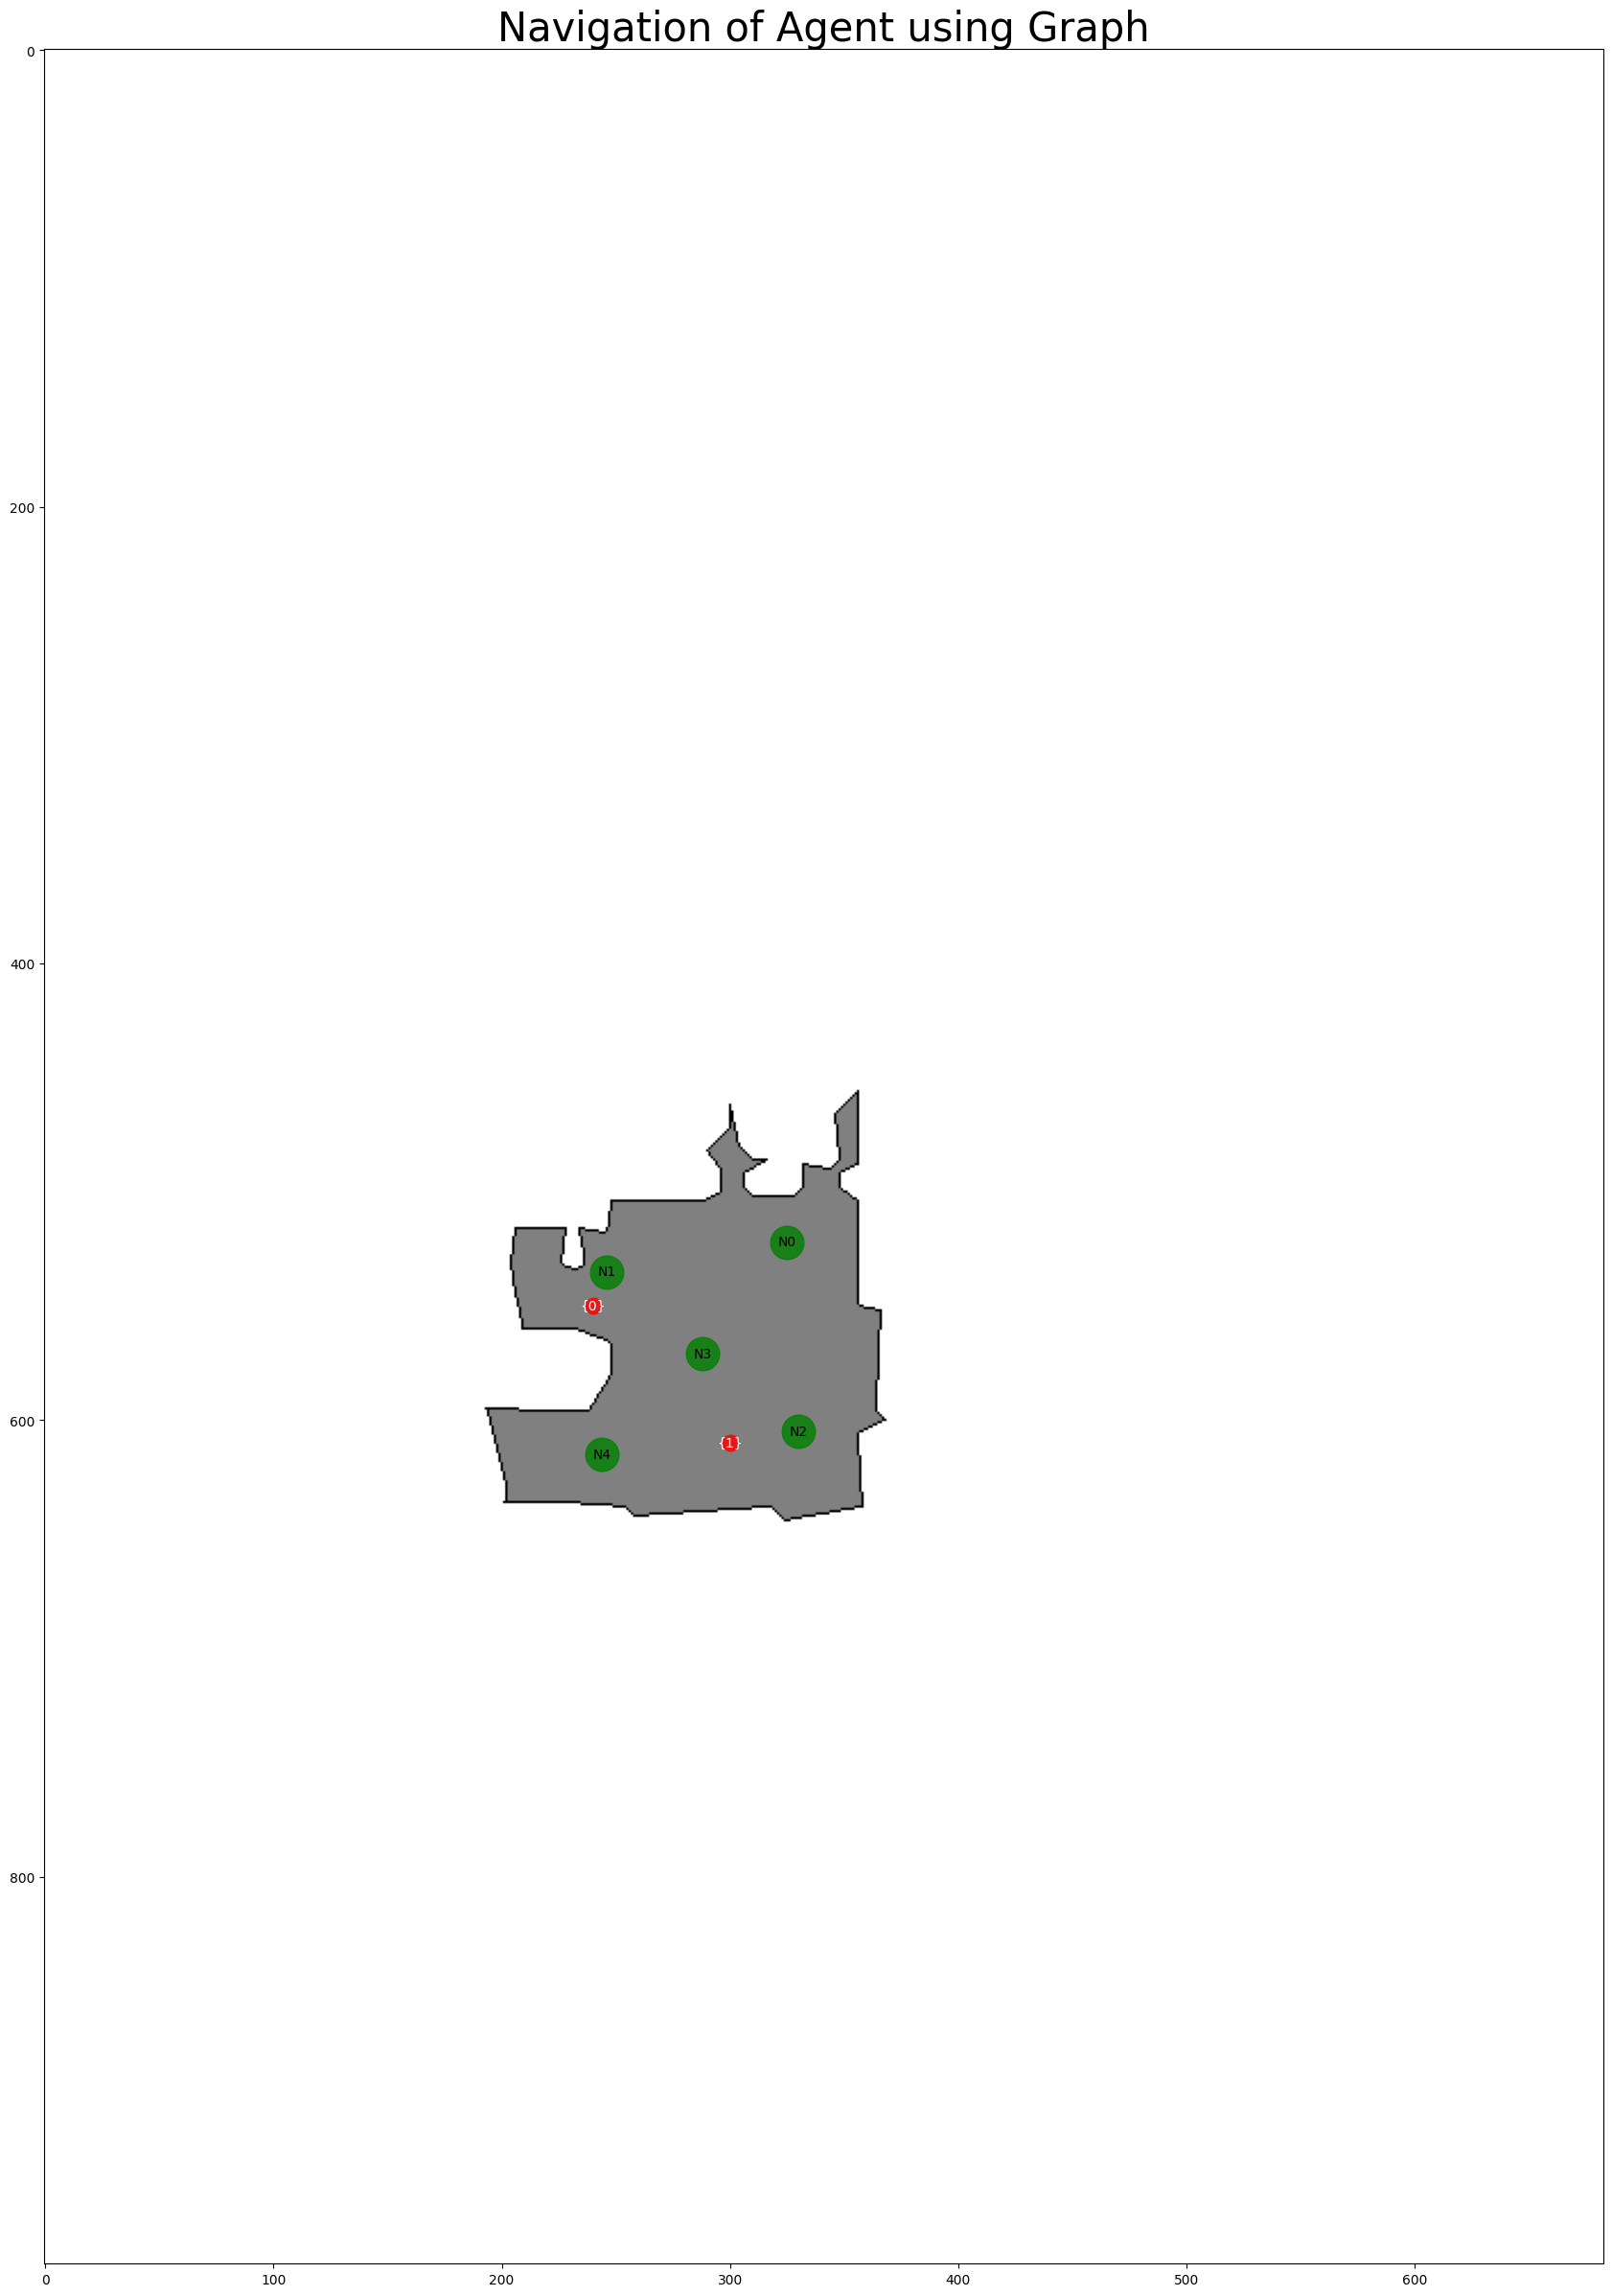

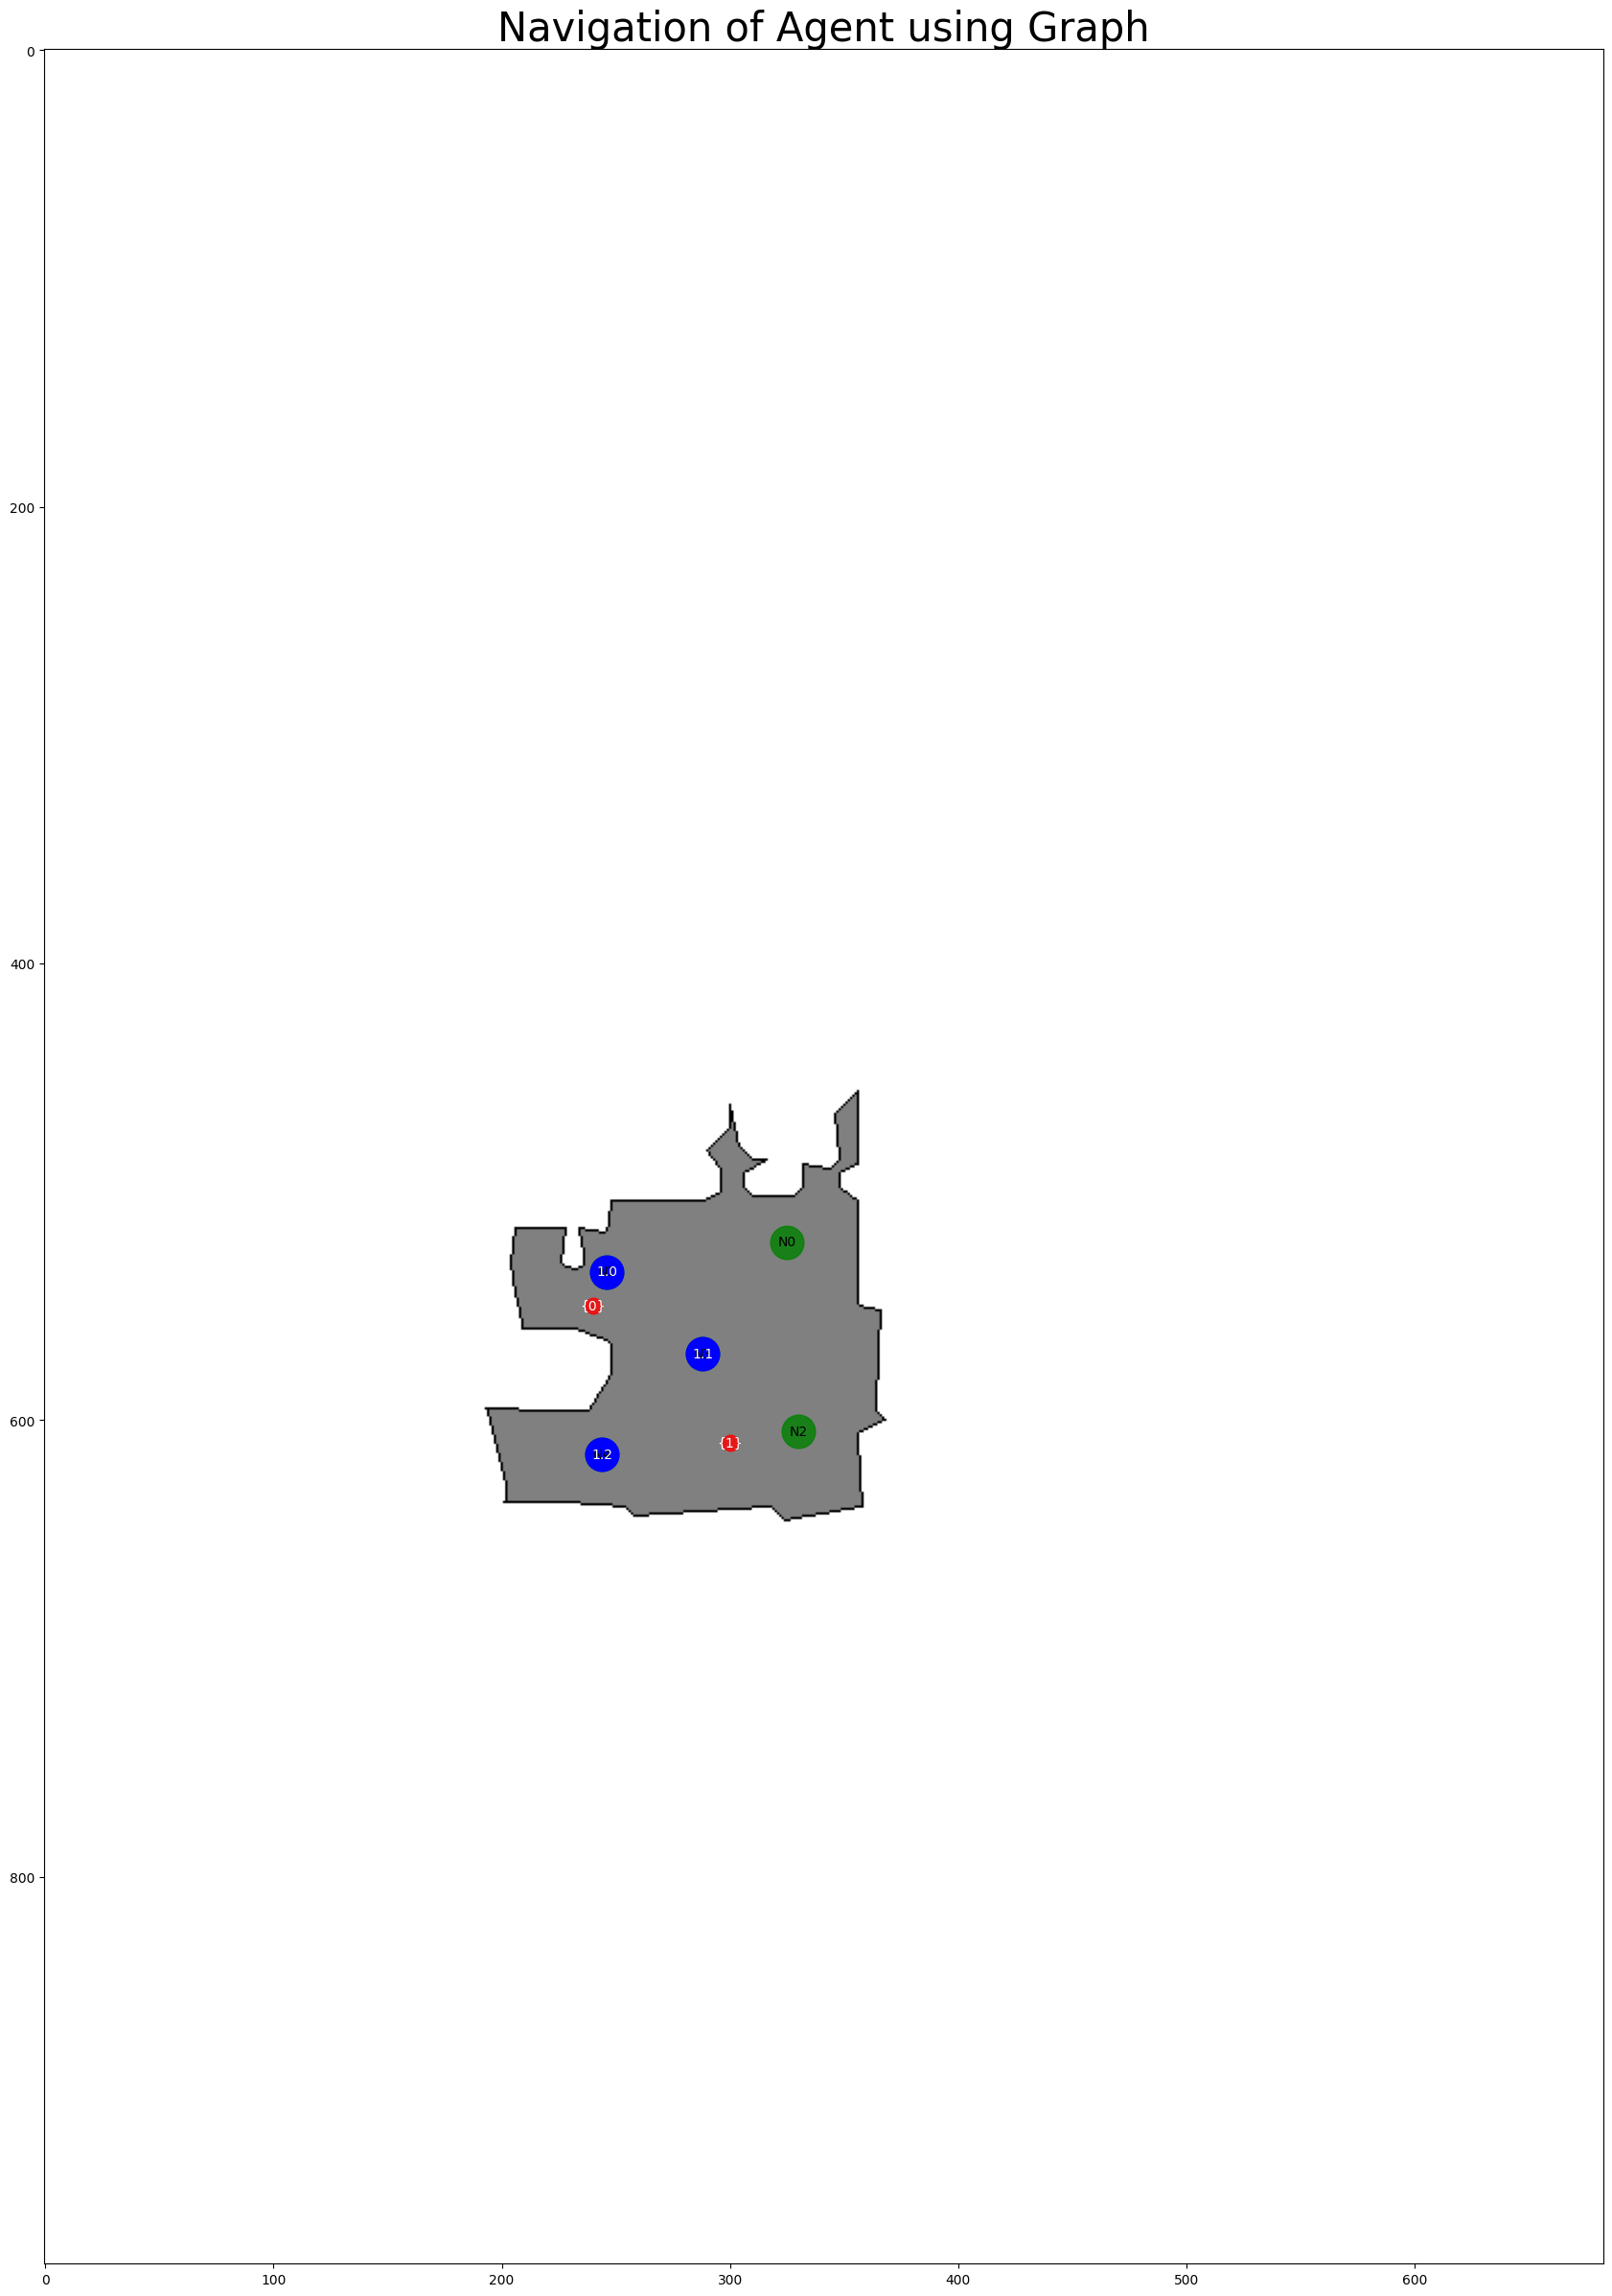

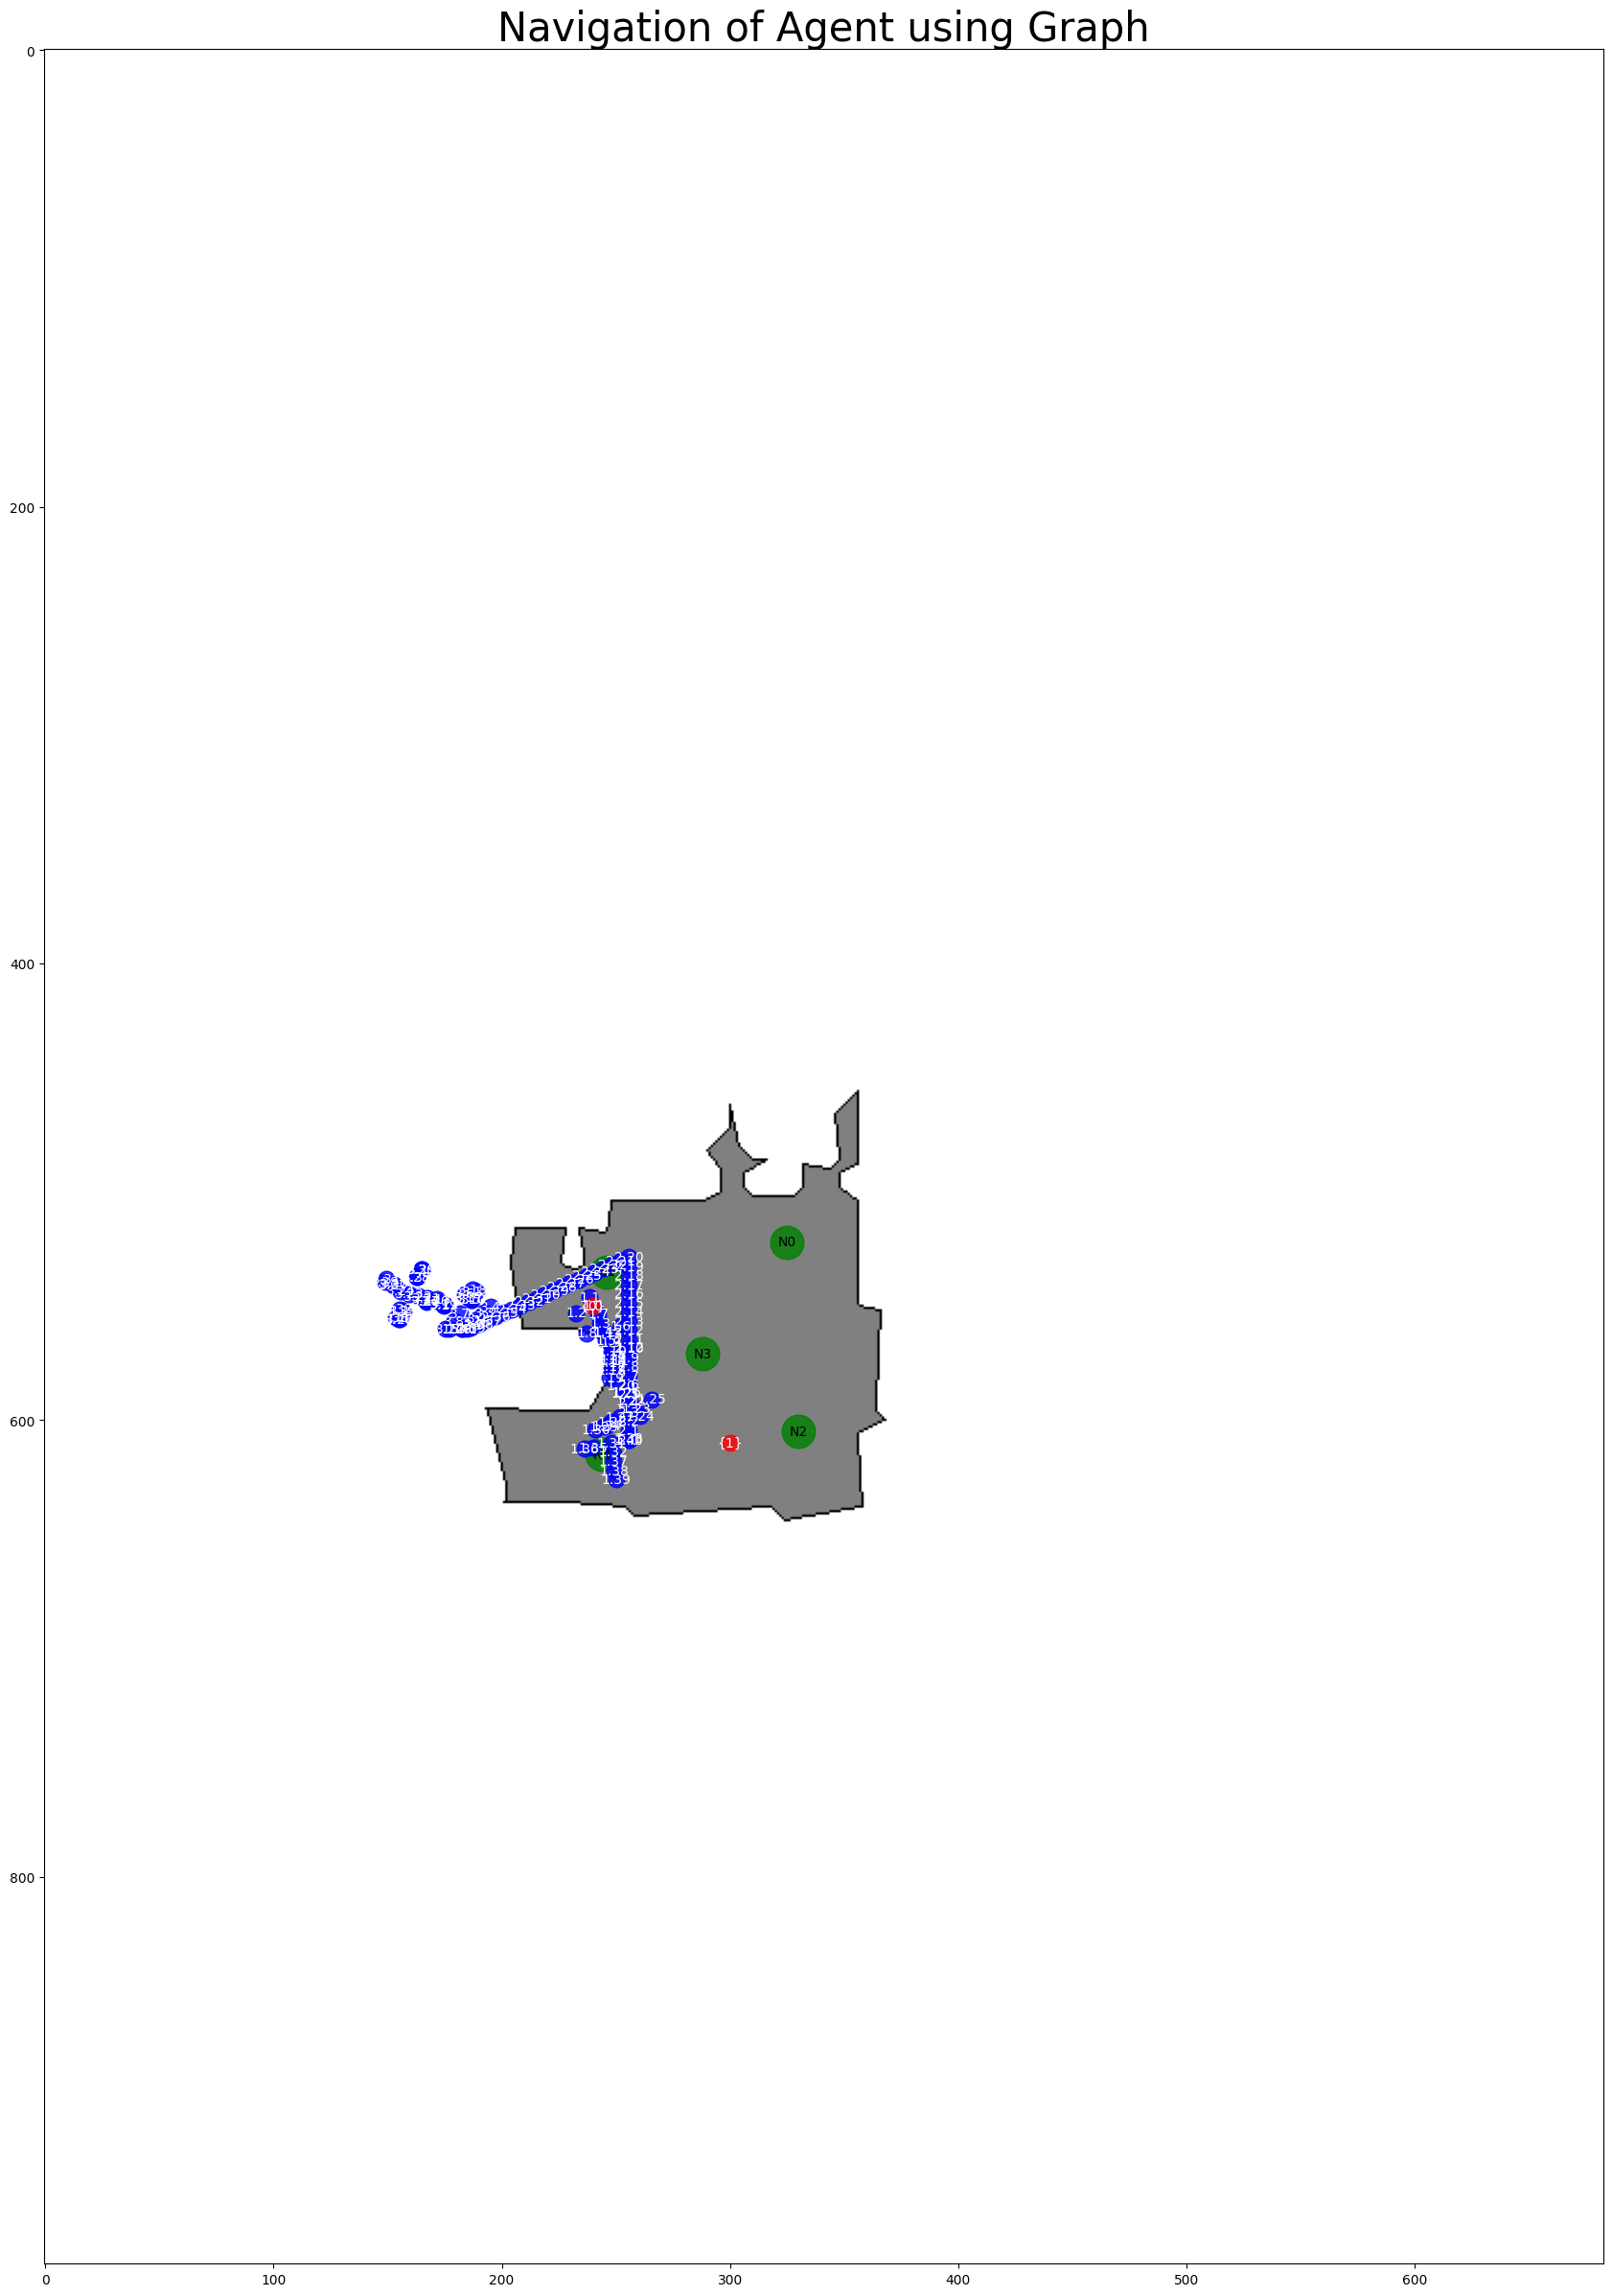

In [123]:
display_graph_navigation_before_agent_movement(top_down_map, points, random_points, [])
display_graph_navigation_before_agent_movement(top_down_map, points, random_points, path)
display_graph_navigation(top_down_map, points, random_points, path1, path2, path3)